# Import Libraries

In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

!pip install category_encoders
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder

from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

!pip install catboost
import catboost as ctb
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

!pip install optuna
import optuna
import tqdm
import joblib
import pickle

import warnings
warnings.filterwarnings('ignore')


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [10]:
import shap
pd.set_option('display.max_column', 70)
plt.rcParams['axes.spines.top']=False
plt.rcParams['axes.spines.right']=False

style.use('ggplot')
sns.set_palette('Set2')

# Import Data

In [11]:
train = pd.read_csv('train_dataset.csv')
test = pd.read_csv('x_test.csv')

In [12]:
df_train = train.copy()
df_test = test.copy()

In [13]:
print(df_train.shape)
print(df_test.shape)

(75757, 64)
(9705, 63)


In [14]:
train

Year_Factor State_Factor building_class  \
0                1      State_1     Commercial   
1                1      State_1     Commercial   
2                1      State_1     Commercial   
3                1      State_1     Commercial   
4                1      State_1     Commercial   
...            ...          ...            ...   
75752            6     State_11     Commercial   
75753            6     State_11    Residential   
75754            6     State_11     Commercial   
75755            6     State_11     Commercial   
75756            6     State_11    Residential   

                                   facility_type  floor_area  year_built  \
0                   Grocery_store_or_food_market     61242.0      1942.0   
1      Warehouse_Distribution_or_Shipping_center    274000.0      1955.0   
2                           Retail_Enclosed_mall    280025.0      1951.0   
3                      Education_Other_classroom     55325.0      1980.0   
4                      Warehouse_Nonrefrigerated     66000.0      1985.0   
...                                          ...         ...         ...   
75752                       Office_Uncategorized     20410.0      1995.0   
75753                        5plus_Unit_Building     40489.0      1910.0   
75754                           Commercial_Other     28072.0      1917.0   
75755                           Commercial_Other     53575.0      2012.0   
75756                         2to4_Unit_Building     23888.0      1974.0   

       energy_star_rating  ELEVATION  january_min_temp  january_avg_temp  \
0                    11.0        2.4                36         50.500000   
1                    45.0        1.8                36         50.500000   
2                    97.0        1.8                36         50.500000   
3                    46.0        1.8                36         50.500000   
4                   100.0        2.4                36         50.500000   
...                   ...        ...               ...               ...   
75752                 8.0       36.6                28         43.451613   
75753                98.0       36.6                28         43.451613   
75754                 NaN       36.6                26         36.612903   
75755                 NaN       36.6                26         36.612903   
75756                51.0       36.6                27         36.935484   

       january_max_temp  february_min_temp  february_avg_temp  \
0                    68                 35          50.589286   
1                    68                 35          50.589286   
2                    68                 35          50.589286   
3                    68                 35          50.589286   
4                    68                 35          50.589286   
...                 ...                ...                ...   
75752                56                 34          47.672414   
75753                56                 34          47.672414   
75754                48                 30          41.637931   
75755                48                 30          41.637931   
75756                51                 29          42.172414   

       february_max_temp  march_min_temp  march_avg_temp  march_max_temp  \
0                     73              40       53.693548              80   
1                     73              40       53.693548              80   
2                     73              40       53.693548              80   
3                     73              40       53.693548              80   
4                     73              40       53.693548              80   
...                  ...             ...             ...             ...   
75752                 64              35       49.354839              71   
75753                 64              35       49.354839              71   
75754                 58              29       41.338710              62   
75755                 58              2

In [15]:
df_train.rename(columns={
    'Year_Factory': 'year_factory',
    'State_Factory': 'state_factory',
    'ELEVATION': 'elevation',
    'id': 'building_id'
}, inplace=True)

df_test.rename(columns={
    'Year_Factory': 'year_factory',
    'State_Factory': 'state_factory',
    'ELEVATION': 'elevation',
    'id': 'building_id'
}, inplace=True)


# EDA

## Understanding features

**year_Factor**: anonymized year in which the weather and energy usage factors were observed  

**state_Factor**: anonymized state in which the building is located  

**building_class**: building classification  

**facility_type**: building usage type  

**floor_area**: floor area (in square feet) of the building  

**year_built**: year in which the building was constructed  

**energy_star_rating**: the energy star rating of the building  

**elevation**: elevation of the building location  

**january_min_temp**: minimum temperature in January (in Fahrenheit) at the location of the building  

**january_avg_temp**: average temperature in January (in Fahrenheit) at the location of the building  

**january_max_temp**: maximum temperature in January (in Fahrenheit) at the location of the building  

[Similarly for all other months]

**cooling_degree_days**: cooling degree day for a given day is the number of degrees where the daily average temperature   
exceeds 65 degrees Fahrenheit. Each month is summed to produce an annual total at the location of the building.  

**heating_degree_days**: heating degree day for a given day is the number of degrees where the daily average temperature   falls under 65 degrees Fahrenheit. Each month is summed to produce an annual total at the location of the building.  

**precipitation_inches**: annual precipitation in inches at the location of the building  

**snowfall_inches**: annual snowfall in inches at the location of the building  

**snowdepth_inches**: annual snow depth in inches at the location of the building  

**avg_temp**: average temperature over a year at the location of the building  

**days_below_30F**: total number of days below 30 degrees Fahrenheit at the location of the building  

**days_below_20F**: total number of days below 20 degrees Fahrenheit at the location of the building  

**days_below_10F**: total number of days below 10 degrees Fahrenheit at the location of the building  

**days_below_0F**: total number of days below 0 degrees Fahrenheit at the location of the building  

**days_above_80F**: total number of days above 80 degrees Fahrenheit at the location of the building  

**days_above_90F**: total number of days above 90 degrees Fahrenheit at the location of the building  

**days_above_100F**: total number of days above 100 degrees Fahrenheit at the location of the building  

**days_above_110F**: total number of days above 110 degrees Fahrenheit at the location of the building  

**direction_max_wind_speed**: wind direction for maximum wind speed at the location of the building. Given in 360-degree compass point directions (e.g. 360 = north, 180 = south, etc.).  

**direction_peak_wind_speed**: wind direction for peak wind gust speed at the location of the building. Given in 360-degree compass point directions (e.g. 360 = north, 180 = south, etc.).  

**max_wind_speed**: maximum wind speed at the location of the building  

**days_with_fog**: number of days with fog at the location of the building  

**building_id**: building id  

### Target
**site_eui**: Site Energy Usage Intensity is the amount of heat and electricity consumed by a building as reflected in utility bills  

In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                75757 non-null  int64  
 1   State_Factor               75757 non-null  object 
 2   building_class             75757 non-null  object 
 3   facility_type              75757 non-null  object 
 4   floor_area                 75757 non-null  float64
 5   year_built                 73920 non-null  float64
 6   energy_star_rating         49048 non-null  float64
 7   elevation                  75757 non-null  float64
 8   january_min_temp           75757 non-null  int64  
 9   january_avg_temp           75757 non-null  float64
 10  january_max_temp           75757 non-null  int64  
 11  february_min_temp          75757 non-null  int64  
 12  february_avg_temp          75757 non-null  float64
 13  february_max_temp          75757 non-null  int

In [17]:
print(df_train.duplicated().sum())
print(df_test.duplicated().sum())

0
0


In [18]:
print([col for col in df_train if df_train[col].nunique()==1])
print([col for col in df_test if df_test[col].nunique()==1])

[]
['Year_Factor', 'days_above_110F']


In [19]:
df_train.head()

Year_Factor State_Factor building_class  \
0            1      State_1     Commercial   
1            1      State_1     Commercial   
2            1      State_1     Commercial   
3            1      State_1     Commercial   
4            1      State_1     Commercial   

                               facility_type  floor_area  year_built  \
0               Grocery_store_or_food_market     61242.0      1942.0   
1  Warehouse_Distribution_or_Shipping_center    274000.0      1955.0   
2                       Retail_Enclosed_mall    280025.0      1951.0   
3                  Education_Other_classroom     55325.0      1980.0   
4                  Warehouse_Nonrefrigerated     66000.0      1985.0   

   energy_star_rating  elevation  january_min_temp  january_avg_temp  \
0                11.0        2.4                36              50.5   
1                45.0        1.8                36              50.5   
2                97.0        1.8                36              50.5   
3                46.0        1.8                36              50.5   
4               100.0        2.4                36              50.5   

   january_max_temp  february_min_temp  february_avg_temp  february_max_temp  \
0                68                 35          50.589286                 73   
1                68                 35          50.589286                 73   
2                68                 35          50.589286                 73   
3                68                 35          50.589286                 73   
4                68                 35          50.589286                 73   

   march_min_temp  march_avg_temp  march_max_temp  april_min_temp  \
0              40       53.693548              80              41   
1              40       53.693548              80              41   
2              40       53.693548              80              41   
3              40       53.693548              80              41   
4              40       53.693548              80              41   

   april_avg_temp  april_max_temp  may_min_temp  may_avg_temp  may_max_temp  \
0            55.5              78            46     56.854839            84   
1            55.5              78            46     56.854839            84   
2            55.5              78            46     56.854839            84   
3            55.5              78            46     56.854839            84   
4            55.5              78            46     56.854839            84   

   june_min_temp  june_avg_temp  june_max_temp  july_min_temp  july_avg_temp  \
0             50           60.5             90             52      62.725806   
1             50           60.5             90             52      62.725806   
2             50           60.5             90             52      62.725806   
3             50           60.5             90             52      62.725806   
4             50           60.5             90             52      62.725806   

   july_max_temp  august_min_temp  august_avg_temp  august_max_temp  \
0             84               52         62.16129               85   
1             84               52         62.16129               85   
2             84               52         62.16129               85   
3             84               52         62.16129               85   
4             84               52         62.16129               85   

   september_min_temp  september_avg_temp  september_max_temp  \
0                  52               64.65                  90   
1                  52               64.65                  90   
2                  52               64.65                  90   
3                  52               64.65                  90   
4                  52               64.65                  90   

   october_min_temp  october_avg_temp  october_max_temp  november_min_temp  \
0                47         63.016129                83                 43   
1                47         63.016

In [20]:
df_test.head()


Year_Factor State_Factor building_class                 facility_type  \
0            7      State_1     Commercial  Grocery_store_or_food_market   
1            7      State_1     Commercial  Grocery_store_or_food_market   
2            7      State_1     Commercial  Grocery_store_or_food_market   
3            7      State_1     Commercial  Grocery_store_or_food_market   
4            7      State_1     Commercial  Grocery_store_or_food_market   

   floor_area  year_built  energy_star_rating  elevation  january_min_temp  \
0     28484.0      1994.0                37.0        2.4                38   
1     21906.0      1961.0                55.0       45.7                38   
2     16138.0      1950.0                 1.0       59.1                38   
3     97422.0      1971.0                34.0       35.4                38   
4     61242.0      1942.0                35.0        1.8                38   

   january_avg_temp  january_max_temp  february_min_temp  february_avg_temp  \
0         50.596774                64                 40          54.482143   
1         50.596774                64                 40          54.482143   
2         50.596774                64                 40          54.482143   
3         50.596774                64                 40          54.482143   
4         50.596774                64                 40          54.482143   

   february_max_temp  march_min_temp  march_avg_temp  march_max_temp  \
0                 66              42       56.935484              77   
1                 66              42       56.935484              77   
2                 66              42       56.935484              77   
3                 66              42       56.935484              77   
4                 66              42       56.935484              77   

   april_min_temp  april_avg_temp  april_max_temp  may_min_temp  may_avg_temp  \
0              45           58.45              78            49     60.903226   
1              45           58.45              78            49     60.903226   
2              45           58.45              78            49     60.903226   
3              45           58.45              78            49     60.903226   
4              45           58.45              78            49     60.903226   

   may_max_temp  june_min_temp  june_avg_temp  june_max_temp  july_min_temp  \
0            87             51          63.15             97             53   
1            87             51          63.15             97             53   
2            87             51          63.15             97             53   
3            87             51          63.15             97             53   
4            87             51          63.15             97             53   

   july_avg_temp  july_max_temp  august_min_temp  august_avg_temp  \
0      64.258065             85               53        65.854839   
1      64.258065             85               53        65.854839   
2      64.258065             85               53        65.854839   
3      64.258065             85               53        65.854839   
4      64.258065             85               53        65.854839   

   august_max_temp  september_min_temp  september_avg_temp  \
0               88                  54           69.766667   
1               88                  54           69.766667   
2               88                  54           69.766667   
3               88                  54           69.766667   
4               88                  54           69.766667   

   september_max_temp  october_min_temp  october_avg_temp  october_max_temp  \
0                 104                48         64.193548                91   
1                 104                48         64.193548                91   
2                 104                48         64.193548                91   
3                 104                48         64.193548                91   
4                 104   

In [21]:
df_train.describe(include ='all')

Year_Factor State_Factor building_class              facility_type  \
count   75757.000000        75757          75757                      75757   
unique           NaN            7              2                         60   
top              NaN      State_6    Residential  Multifamily_Uncategorized   
freq             NaN        50840          43558                      39455   
mean        4.367755          NaN            NaN                        NaN   
std         1.471441          NaN            NaN                        NaN   
min         1.000000          NaN            NaN                        NaN   
25%         3.000000          NaN            NaN                        NaN   
50%         5.000000          NaN            NaN                        NaN   
75%         6.000000          NaN            NaN                        NaN   
max         6.000000          NaN            NaN                        NaN   

          floor_area    year_built  energy_star_rating     elevation  \
count   7.575700e+04  73920.000000        49048.000000  75757.000000   
unique           NaN           NaN                 NaN           NaN   
top              NaN           NaN                 NaN           NaN   
freq             NaN           NaN                 NaN           NaN   
mean    1.659839e+05   1952.306764           61.048605     39.506323   
std     2.468758e+05     37.053619           28.663683     60.656596   
min     9.430000e+02      0.000000            0.000000     -6.400000   
25%     6.237900e+04   1927.000000           40.000000     11.900000   
50%     9.136700e+04   1951.000000           67.000000     25.000000   
75%     1.660000e+05   1977.000000           85.000000     42.700000   
max     6.385382e+06   2015.000000          100.000000   1924.500000   

        january_min_temp  january_avg_temp  january_max_temp  \
count       75757.000000      75757.000000      75757.000000   
unique               NaN               NaN               NaN   
top                  NaN               NaN               NaN   
freq                 NaN               NaN               NaN   
mean           11.432343         34.310468         59.054952   
std             9.381027          6.996108          5.355458   
min           -19.000000         10.806452         42.000000   
25%             6.000000         29.827586         56.000000   
50%            11.000000         34.451613         59.000000   
75%            13.000000         37.322581         62.000000   
max            49.000000         64.758065         91.000000   

        february_min_temp  february_avg_temp  february_max_temp  \
count        75757.000000       75757.000000       75757.000000   
unique                NaN                NaN                NaN   
top                   NaN                NaN                NaN   
freq                  NaN                NaN                NaN   
mean            11.720567          35.526837          58.486278   
std             12.577272           8.866697           8.414611   
min            -13.000000          13.250000          38.000000   
25%              2.000000          31.625000          55.000000   
50%              9.000000          34.107143          61.000000   
75%             20.000000          40.879310          62.000000   
max             48.000000          65.107143          89.000000   

        march_min_temp  march_avg_temp  march_max_temp  april_min_temp  \
count     75757.000000    75757.000000    75757.000000    75757.000000   
unique             NaN             NaN             NaN             NaN   
top                NaN             NaN             NaN             NaN   
freq               NaN             NaN             NaN             NaN   
mean         21.606281       44.469292       70.897831       32.037171   
std          10.004303        6.657142        7.680982        5.577279   
min          -9.000000       25.854839       53.000000       15.000000   
25%          13.000000       

In [22]:
df_test.describe(include ='all')

Year_Factor State_Factor building_class              facility_type  \
count        9705.0         9705           9705                       9705   
unique          NaN            6              2                         60   
top             NaN     State_11     Commercial  Multifamily_Uncategorized   
freq            NaN         3268           5607                       2199   
mean            7.0          NaN            NaN                        NaN   
std             0.0          NaN            NaN                        NaN   
min             7.0          NaN            NaN                        NaN   
25%             7.0          NaN            NaN                        NaN   
50%             7.0          NaN            NaN                        NaN   
75%             7.0          NaN            NaN                        NaN   
max             7.0          NaN            NaN                        NaN   

          floor_area   year_built  energy_star_rating    elevation  \
count   9.705000e+03  9613.000000         7451.000000  9705.000000   
unique           NaN          NaN                 NaN          NaN   
top              NaN          NaN                 NaN          NaN   
freq             NaN          NaN                 NaN          NaN   
mean    1.632143e+05  1963.219598           64.712924   205.231190   
std     2.624759e+05    40.819953           27.935984   264.822814   
min     5.982000e+03     0.000000            1.000000     1.800000   
25%     4.802000e+04  1929.000000           45.000000    26.500000   
50%     8.248600e+04  1969.000000           72.000000   118.900000   
75%     1.775200e+05  1994.000000           88.000000   231.300000   
max     6.353396e+06  2016.000000          100.000000   812.000000   

        january_min_temp  january_avg_temp  january_max_temp  \
count        9705.000000       9705.000000       9705.000000   
unique               NaN               NaN               NaN   
top                  NaN               NaN               NaN   
freq                 NaN               NaN               NaN   
mean           13.520762         36.678081         60.008449   
std            12.458365          6.968520          5.874699   
min            -1.000000         27.548387         42.000000   
25%            -1.000000         27.548387         54.000000   
50%            15.000000         38.661290         59.000000   
75%            21.000000         41.177419         64.000000   
max            38.000000         50.596774         71.000000   

        february_min_temp  february_avg_temp  february_max_temp  \
count         9705.000000        9705.000000        9705.000000   
unique                NaN                NaN                NaN   
top                   NaN                NaN                NaN   
freq                  NaN                NaN                NaN   
mean            21.705100          41.634886          66.940958   
std              9.774624           5.528689           6.397885   
min              9.000000          33.428571          52.000000   
25%              9.000000          36.053571          59.000000   
50%             22.000000          41.625000          69.000000   
75%             28.000000          45.685185          73.000000   
max             40.000000          54.482143          76.000000   

        march_min_temp  march_avg_temp  march_max_temp  april_min_temp  \
count      9705.000000     9705.000000     9705.000000     9705.000000   
unique             NaN             NaN             NaN             NaN   
top                NaN             NaN             NaN             NaN   
freq               NaN             NaN             NaN             NaN   
mean         23.146419       43.568863       71.160639       34.715920   
std          11.553421        6.321471        9.369843        5.395467   
min           8.000000       35.935484       53.000000       28.000000   
25%          12.000000       37.354839       59.000000       29.

In [23]:
def missing_values_table(df):
        # Total missing values by column
        mis_val = df.isnull().sum()
        
        # Percentage of missing values by column
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # build a table with the  columns
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns


In [24]:
print("Train set columns with null values: ")
print(list(df_train.columns[df_train.isnull().any()]))
print('===========================================')
missing_values_train = missing_values_table(df_train)
missing_values_train[:20].style.background_gradient(cmap='Reds')

Train set columns with null values: 
['year_built', 'energy_star_rating', 'direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']
Your selected dataframe has 64 columns.
There are 6 columns that have missing values.


In [25]:
print("Test set columns with null values: ")
print(list(df_test.columns[df_test.isnull().any()]))
print('===========================================')
missing_values_test = missing_values_table(df_test)
missing_values_test[:20].style.background_gradient(cmap='Reds')

Test set columns with null values: 
['year_built', 'energy_star_rating', 'direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']
Your selected dataframe has 63 columns.
There are 6 columns that have missing values.


In [26]:
df_test[['Year_Factor', 'days_above_110F']]

Year_Factor  days_above_110F
0               7                0
1               7                0
2               7                0
3               7                0
4               7                0
...           ...              ...
9700            7                0
9701            7                0
9702            7                0
9703            7                0
9704            7                0

[9705 rows x 2 columns]

### Observations:   
   
1) `year_built`, `energy_star_rating`, `direction_max_wind_speed`, `direction_peak_wind_speed`, `max_wind_speed`, `days_with_fog` variables have `NA` values.   
2) Data contains 75757 samples and 64 features. We have 3 categorical and rest numerical features. Target is numerical.   
3) There are no duplicates in individual dataset, however there might be duplicates in the combined version   
4) there are no constant columns in train dataset, but test dataset has 2 constant columns 

In [27]:
test['site_eui'] = np.nan #63
test['site_eui'].fillna(0)
test['dataset'] = 'test'
train['dataset'] = 'train'
df_all = pd.concat([train, test], axis=0, ignore_index=True)

The dataset contains time variable, `Year_Factor`, that has values from 1 to 7. Assuming the values are consecutive years,`train` dataset contains the first 6 years and `test` set contains the 7th year.

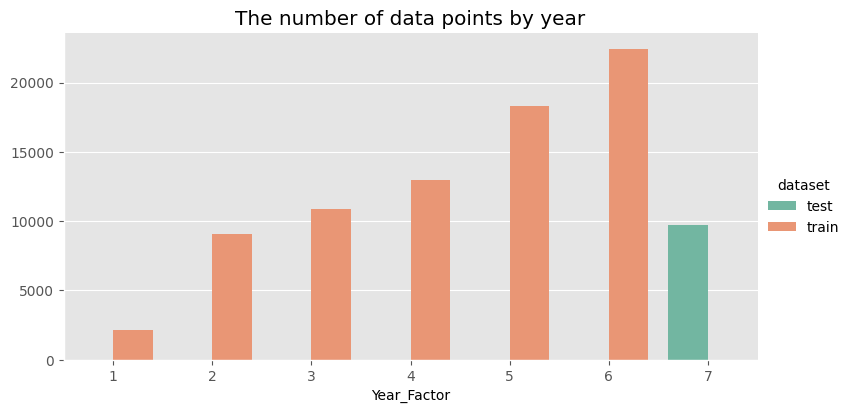

In [28]:
ax = sns.catplot(x='Year_Factor', 
                 y='id', 
                 data=df_all.groupby(['dataset','Year_Factor']).agg({'id':'count'}).reset_index(),
                 hue='dataset',
                 kind='bar',
                 aspect=2,
                 height=4)\
.set(title="The number of data points by year",
     ylabel=None)

`train` set contains data points of 7 states, however, `test` doesn't have any data point from `State_6`.

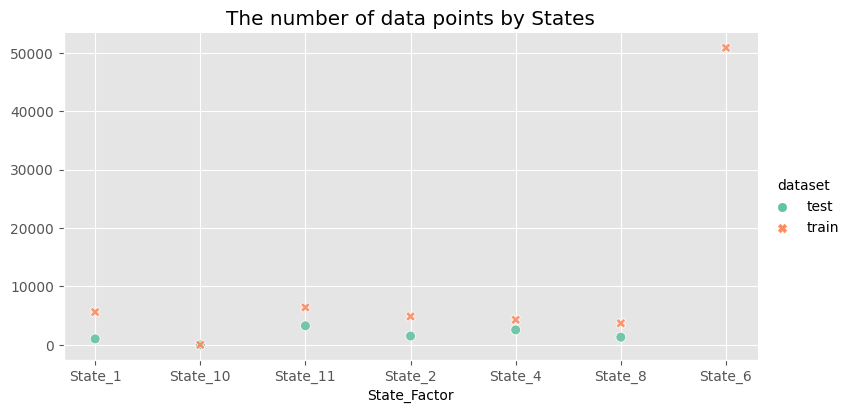

In [29]:
ax = sns.relplot(x='State_Factor', 
                 y='id', 
                 data=df_all.groupby(['dataset','State_Factor']).agg({'id':'count'}).reset_index(),
                 hue='dataset',
                 style='dataset',
                 aspect=2,
                 height=4,
                 s=50,
                 alpha=0.9
                 )\
.set(title = "The number of data points by States",
    ylabel=None)
plt.show()

Both residential and commercial buildings are present in both datasets. `train` data contains more residential buildings compared to `test` set which is due to the number of`State_6` buildings in `train` set which seems to add to the number. Apart from `State_6`, the number of commercial buildings are higher than the residential buildings and `State_10` only contains commercial buildings. The type of building and state could be important factors in determining `EUI`.

Text(0.5, 0, '')

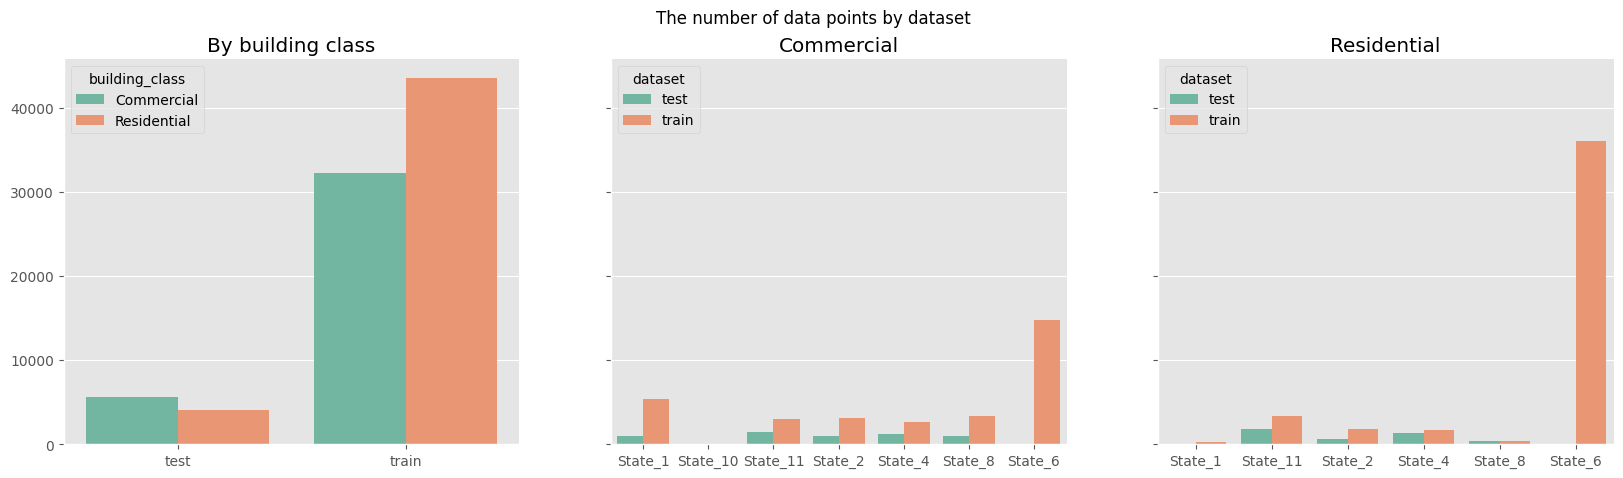

In [30]:
fig, ax = plt.subplots(1,3, figsize=(20,5), sharey=True)
fig.suptitle("The number of data points by dataset")

sns.barplot(x='dataset',
            y='id',
            data=df_all.groupby(['dataset','building_class']).agg({'id':'count'}).reset_index(),
            hue='building_class',
            ax=ax[0],
            ci=False)

for e, s in enumerate(df_all['building_class'].unique(),1):
    sns.barplot(x='State_Factor',
                y='id',
                data=df_all[df_all['building_class']==s].groupby(['dataset','State_Factor']).agg({'id':'count'}).reset_index(),
                hue='dataset',
                ax=ax[e],
                ci=False)
    ax[e].set_title(s)
    ax[e].set_ylabel("")
    ax[e].set_xlabel("")

ax[0].set_title("By building class")
ax[0].set_ylabel("")
ax[0].set_xlabel("")

All facility types are present in both datasets. Almost 90% of residential `Multifamily_uncategorized` buildings and 50% of `Office_uncategorized` are in `State_6` of the training set. Not quite sure how `State_6` will affect the model learning and prediction.

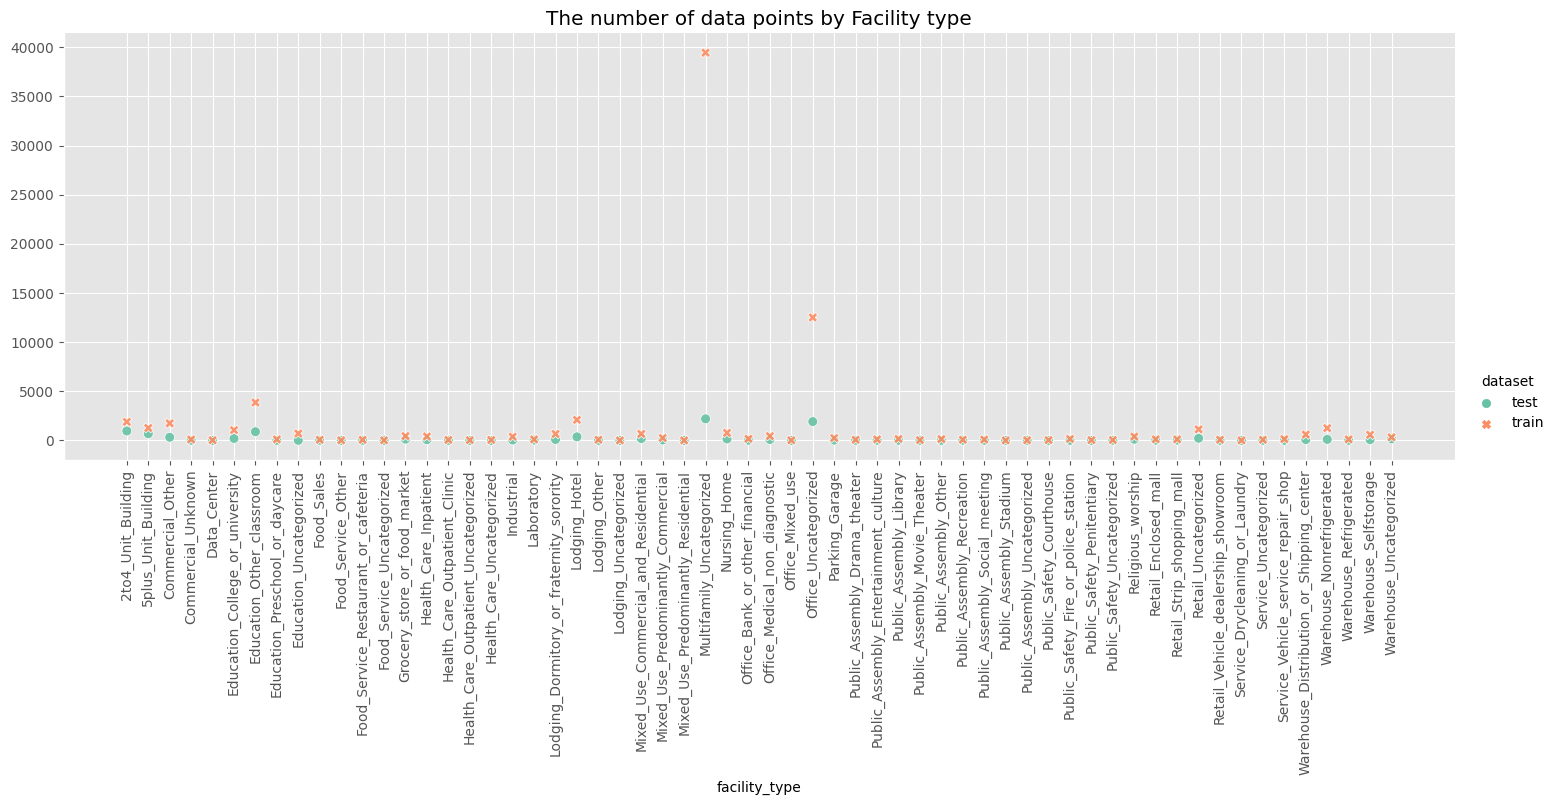

In [31]:
ax = sns.relplot(x='facility_type', 
                 y='id', 
                 data=df_all.groupby(['dataset','facility_type']).agg({'id':'count'}).reset_index(),
                 hue='dataset',
                 style='dataset',
                 aspect=3,
                 height=5,
                 s=50,
                 alpha=0.9
                )\
.set(title = "The number of data points by Facility type",
    ylabel=None)

ax.set_xticklabels(rotation=90) 
None

The oldest building was built in 1600 and the latest in 2016. The majority of the buildings were built since 1900. There were some 0 and null values. Not quite sure what 0 signifies.

In [32]:
df_all['year_built'].value_counts().index.sort_values()

Float64Index([   0.0, 1600.0, 1649.0, 1732.0, 1756.0, 1789.0, 1799.0, 1800.0,
              1811.0, 1815.0,
              ...
              2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0,
              2015.0, 2016.0],
             dtype='float64', length=183)

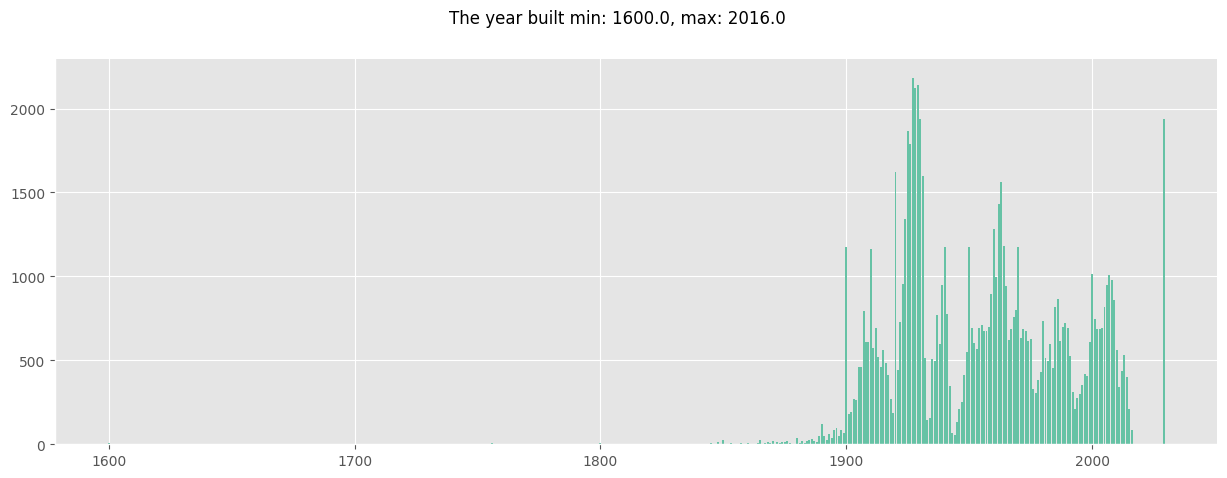

In [33]:
temp = df_all[['year_built']].fillna(2029).replace({0:2029}).astype('category').value_counts().reset_index().rename({0:'count'},axis=1)\
            .sort_values('year_built')
# temp['year_built'] = temp['year_built'].astype('category')
fig, ax = plt.subplots(figsize=(15,5))

ax=plt.bar(temp['year_built'],
           temp['count']
          )

fig.suptitle(f"The year built min: {min(temp['year_built'])}, max: {max(df_all['year_built'])}");

`train` set buildings have higher floor areas compared to `test` set buildings and small positive correlation between `floor_area` and `energy_star_rating` can be observable. 

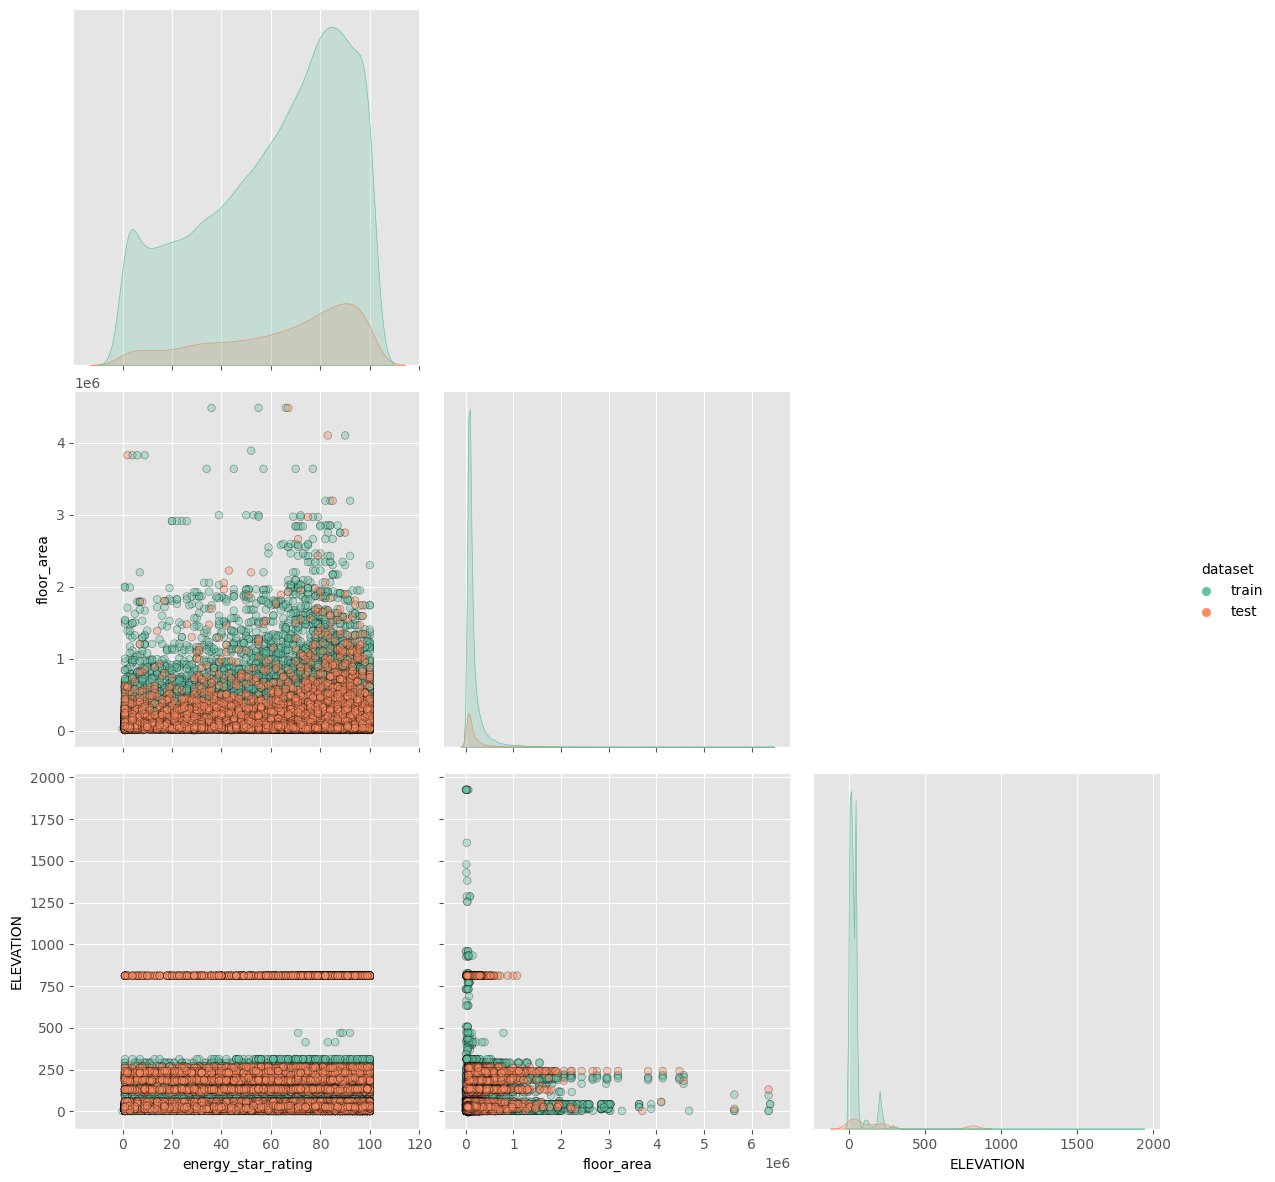

In [34]:
sns.pairplot(df_all,
            vars=['energy_star_rating','floor_area','ELEVATION'], 
            hue='dataset',
            height=4,
            plot_kws = {'alpha': 0.4, 's': 30, 'edgecolor': 'k'},
            corner=True
           );

According to the average temperature (`avg_temp`), if we list states from warmest to coldest: State 1, State 10, State 2, and State 8. The range of temperatures of State1, State 6,  State 11 and State 4 are higher compared to the other states. 

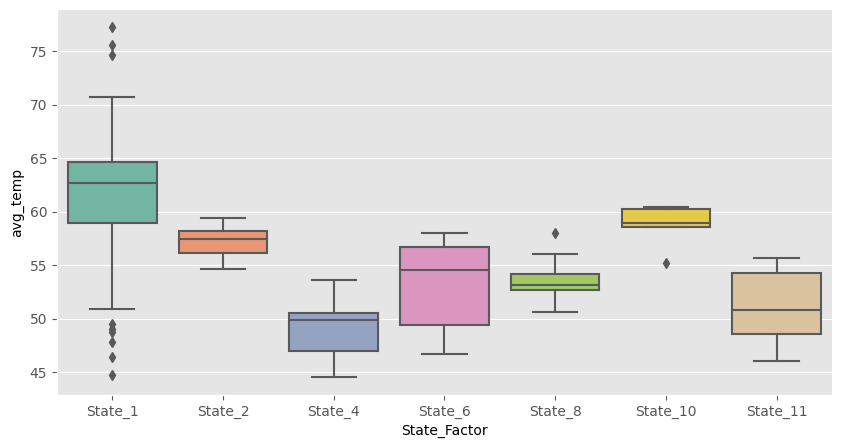

In [35]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=df_all[['avg_temp','State_Factor']].drop_duplicates(), y='avg_temp', x='State_Factor');
# any one categorical col (with low unique vals)

Each month has unique temperature values between 31 and 59 which means the values in temperature volumes are highly repeated for the data points.

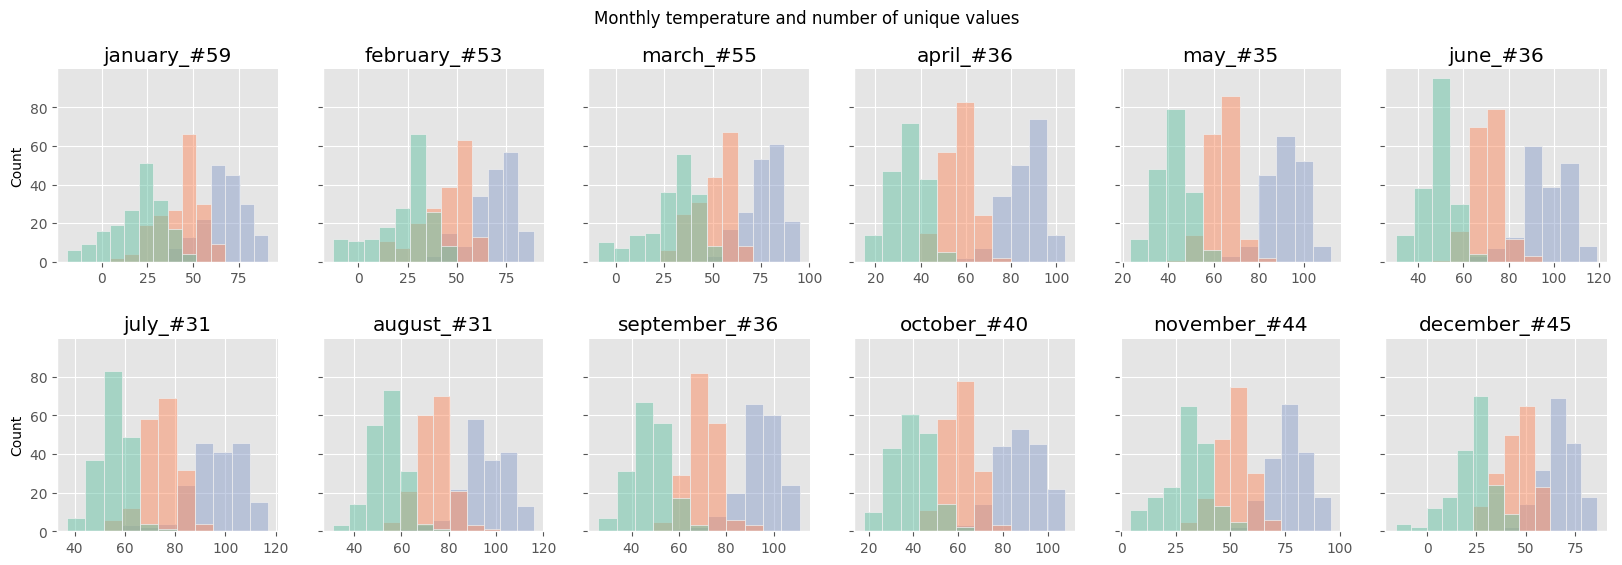

In [36]:
cols = [['january_min_temp', 'january_avg_temp', 'january_max_temp'],
        ['february_min_temp', 'february_avg_temp', 'february_max_temp'],
        ['march_min_temp', 'march_avg_temp', 'march_max_temp'], 
        ['april_min_temp','april_avg_temp', 'april_max_temp'], 
        ['may_min_temp', 'may_avg_temp','may_max_temp'], 
        ['june_min_temp', 'june_avg_temp', 'june_max_temp'],
        ['july_min_temp', 'july_avg_temp', 'july_max_temp'], 
        ['august_min_temp','august_avg_temp', 'august_max_temp'], 
        ['september_min_temp','september_avg_temp', 'september_max_temp'], 
        ['october_min_temp','october_avg_temp', 'october_max_temp'], 
        ['november_min_temp','november_avg_temp', 'november_max_temp'], 
        ['december_min_temp','december_avg_temp', 'december_max_temp']]
        
fig, ax = plt.subplots(2, 6, figsize=(20,6), sharey=True)
fig.suptitle("Monthly temperature and number of unique values")

for e, c in enumerate(cols):
    if e<=5:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[0,e], legend=False)\
        .set(title=c[0][:c[0].find('_')]+ '_#'+str(len(df_all[c[0]].unique())))
    else:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[1,e-6], legend=False)\
        .set(title=c[0][:c[0].find('_')]+ '_#'+str(len(df_all[c[0]].unique())))
        
plt.subplots_adjust(hspace=0.4)

Other weather related numerical columns also have few unique values.

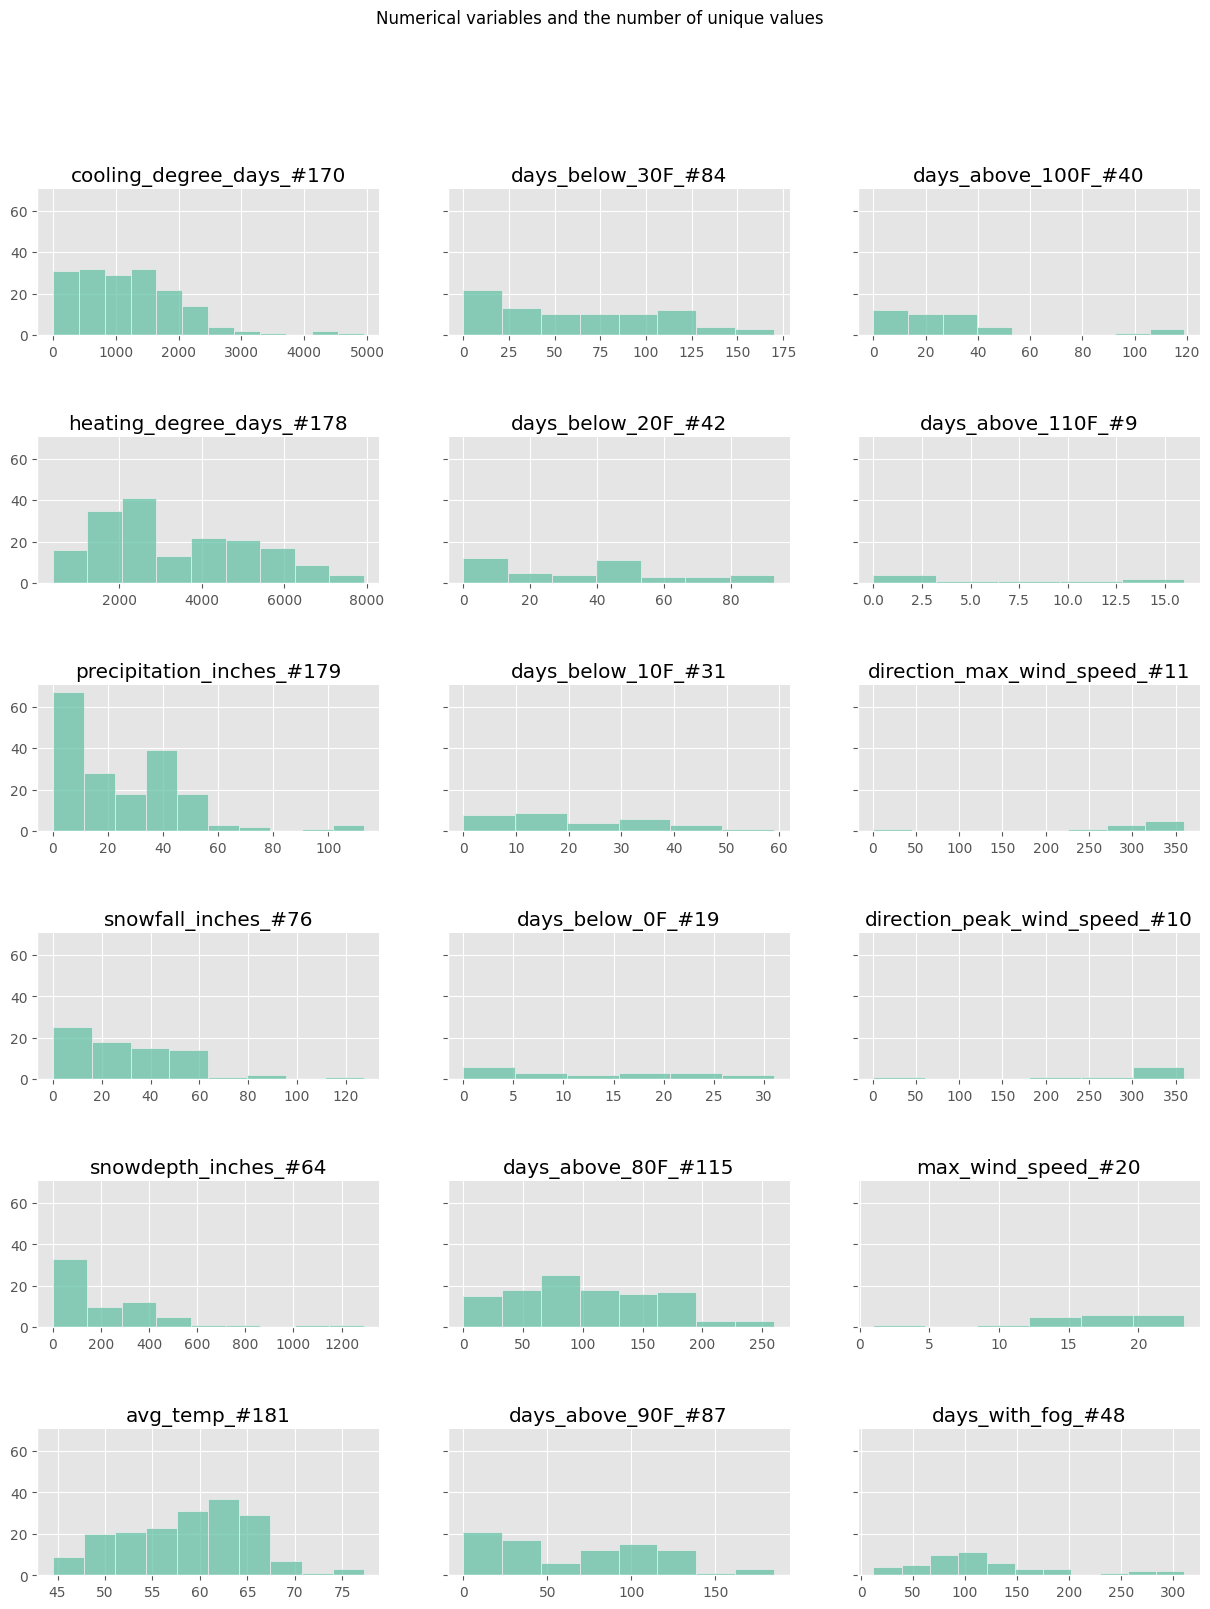

In [37]:
cols=['cooling_degree_days','heating_degree_days', 'precipitation_inches', 'snowfall_inches',
       'snowdepth_inches', 'avg_temp', 'days_below_30F', 'days_below_20F',
       'days_below_10F', 'days_below_0F', 'days_above_80F', 'days_above_90F',
       'days_above_100F', 'days_above_110F', 'direction_max_wind_speed',
       'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']

fig, ax = plt.subplots(6,3, figsize=(15,18), sharey=True)
fig.suptitle("Numerical variables and the number of unique values")

for e, c in enumerate(cols):
    if e<=5:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[e,0], legend=False)\
        .set(title=c+"_#"+str(len(df_all[c].unique())), ylabel=None, xlabel=None)
    elif (e>=6) & (e<=11):
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[e-6,1], legend=False)\
        .set(title=c+"_#"+str(len(df_all[c].unique())), ylabel=None, xlabel=None)
    else:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[e-12,2], legend=False)\
        .set(title=c+"_#"+str(len(df_all[c].unique())), ylabel=None, xlabel=None)
        
plt.subplots_adjust(hspace=0.7)

### Target Variable Exploration (EUI)

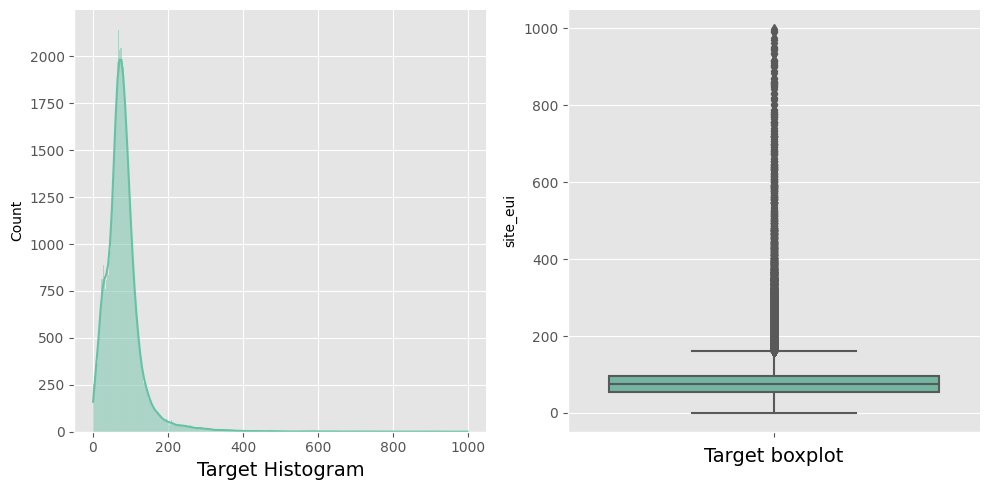

In [38]:
plt.figure(figsize=(10,5))
ax1 = plt.subplot(1,2,1)
cp = sns.histplot(x=df_all['site_eui'], kde=True, palette='Set2')
ax1.set_xlabel('Target Histogram', fontsize=14)
ax2 = plt.subplot(1,2,2)
sns.boxplot(y=df_all['site_eui'], palette='Set2')
ax2.set_xlabel('Target boxplot', fontsize=14)
plt.tight_layout();

State 2 and 4 have slightly higher EUI and State 11 and 8 have lower EUI level.

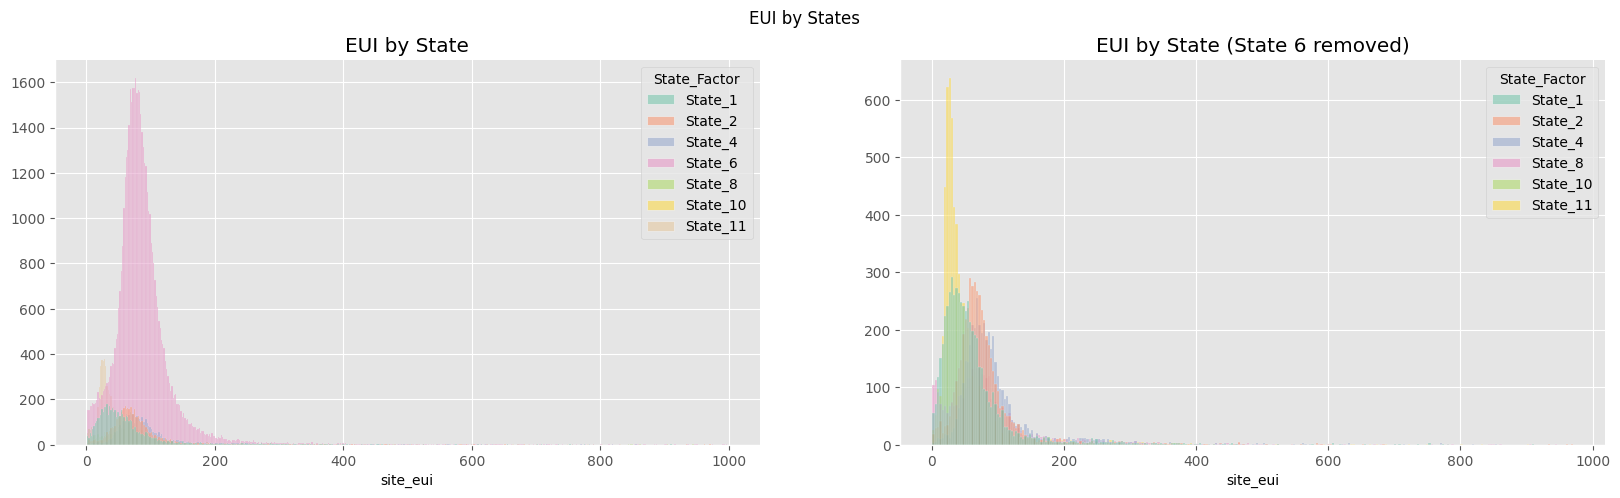

In [39]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
fig.suptitle("EUI by States")

sns.histplot(df_all, x='site_eui',hue='State_Factor', ax=ax[0])\
.set(title='EUI by State', ylabel=None)

sns.histplot(df_all[df_all['State_Factor']!='State_6'], x='site_eui', hue='State_Factor', ax=ax[1])\
.set(title='EUI by State (State 6 removed)', ylabel=None);

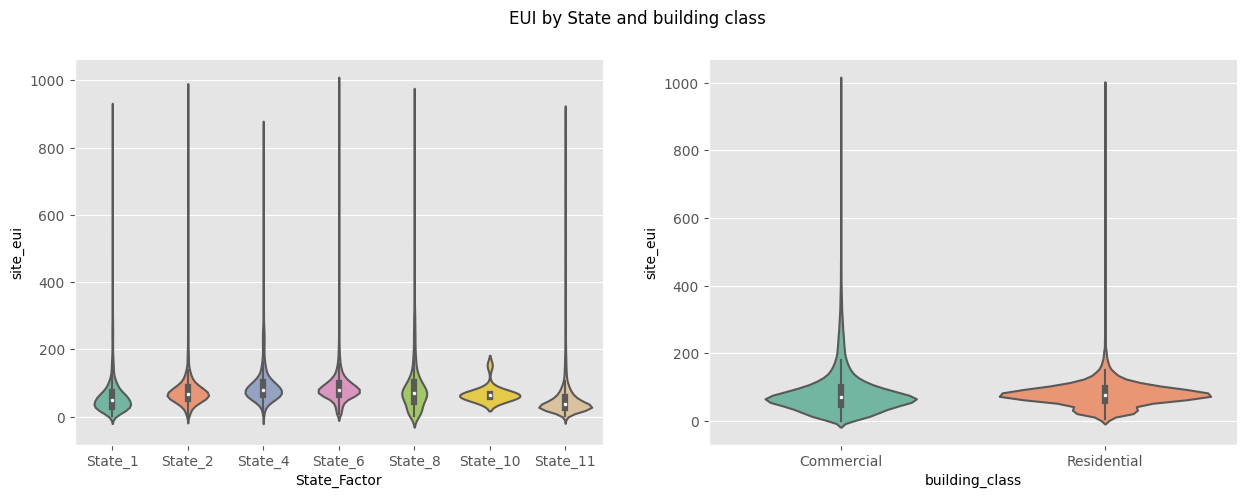

In [40]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
fig.suptitle("EUI by State and building class")

sns.violinplot(data=df_all, y='site_eui', x='State_Factor', ax=ax[0])
sns.violinplot(data=df_all, y='site_eui', x='building_class', ax=ax[1]);

Labs and Data Centers have higher EUI compared to the other types of buildings. Grocery stores, Health Care Inpatient, Health Care Uncategorized, Health Care Outpatient, and Food service, restaurants have higher range of EUI. It could be the essential services must operate for longer hours, therefore, have higher EUI.

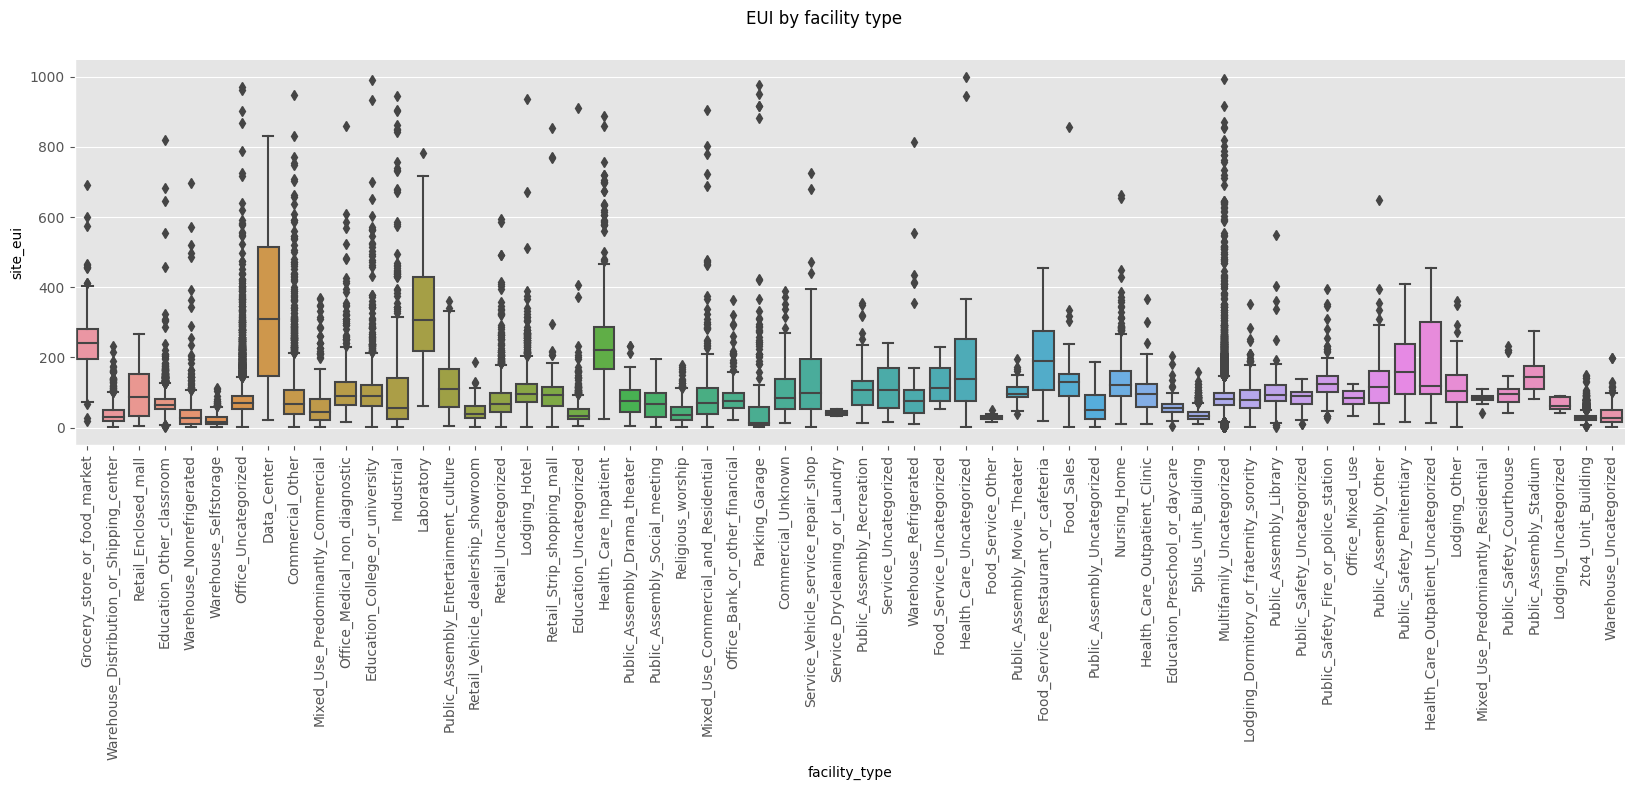

In [41]:
fig, ax = plt.subplots(figsize=(20,5))
fig.suptitle("EUI by facility type")
ax=sns.boxplot(data=df_all, y='site_eui', x='facility_type')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

`floor_area` could have positive relationship with `EUI`. The younger buildings tend to have higher `EUI` which could be because building height and size have increased over the years. It looks like the Higher the `energy_star_rating` is, the lower the `EUI` becomes.

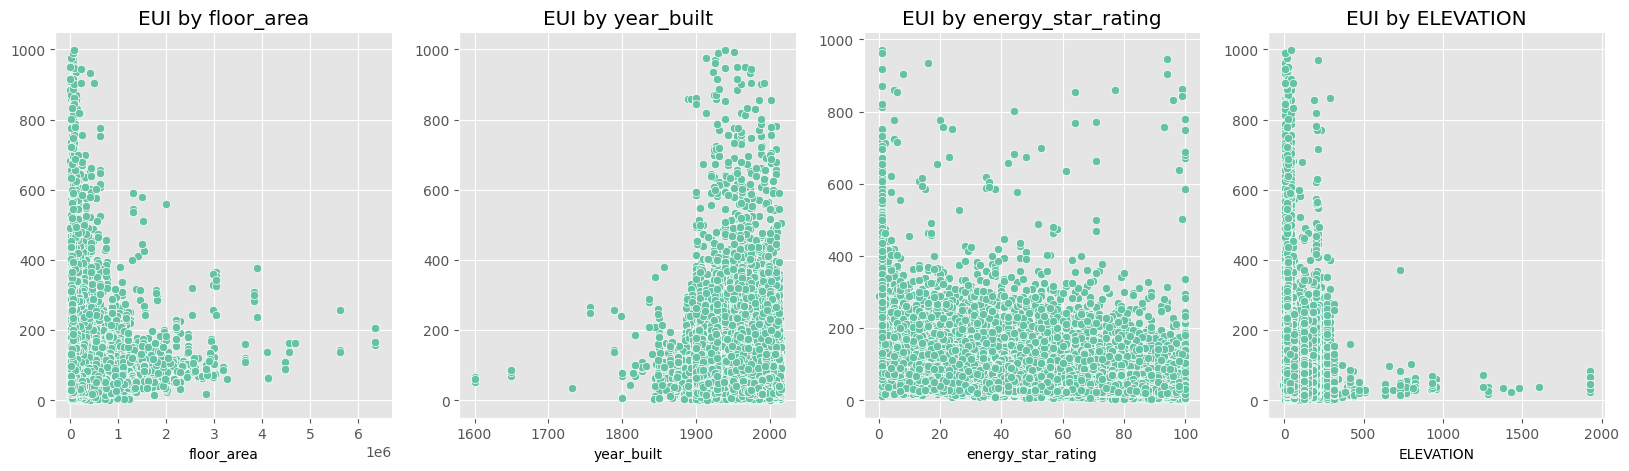

In [42]:
fig, ax = plt.subplots(1,4, figsize=(20,5))

for e, col in enumerate(['floor_area', 'year_built', 'energy_star_rating', 'ELEVATION']):
    if col =='year_built':
        sns.scatterplot(data=df_all[(df_all['year_built']!=0) & (df_all['year_built'].notna())], 
                        x=col, y='site_eui', ax=ax[e]).set(title='EUI by '+ col, ylabel=None)
    else:
        sns.scatterplot(data=df_all, x=col, y='site_eui', ax=ax[e]).set(title='EUI by '+ col, ylabel=None);

The most data points are in lower number of `cooling_degree_days` and higher number of`heating_degree_days`. The majority of the datapoints are also in the lower levels of `snowfall_inches` and `snowdepth_inches`. `direction_max_wind_speed`, `direction_peak_wind_speed`, `max_wind_speed`, and `days_with_fog` columns have the `NA` values of over 50%. No relationship between `EUI` and the weather related numerica columns can be observed from the plot.

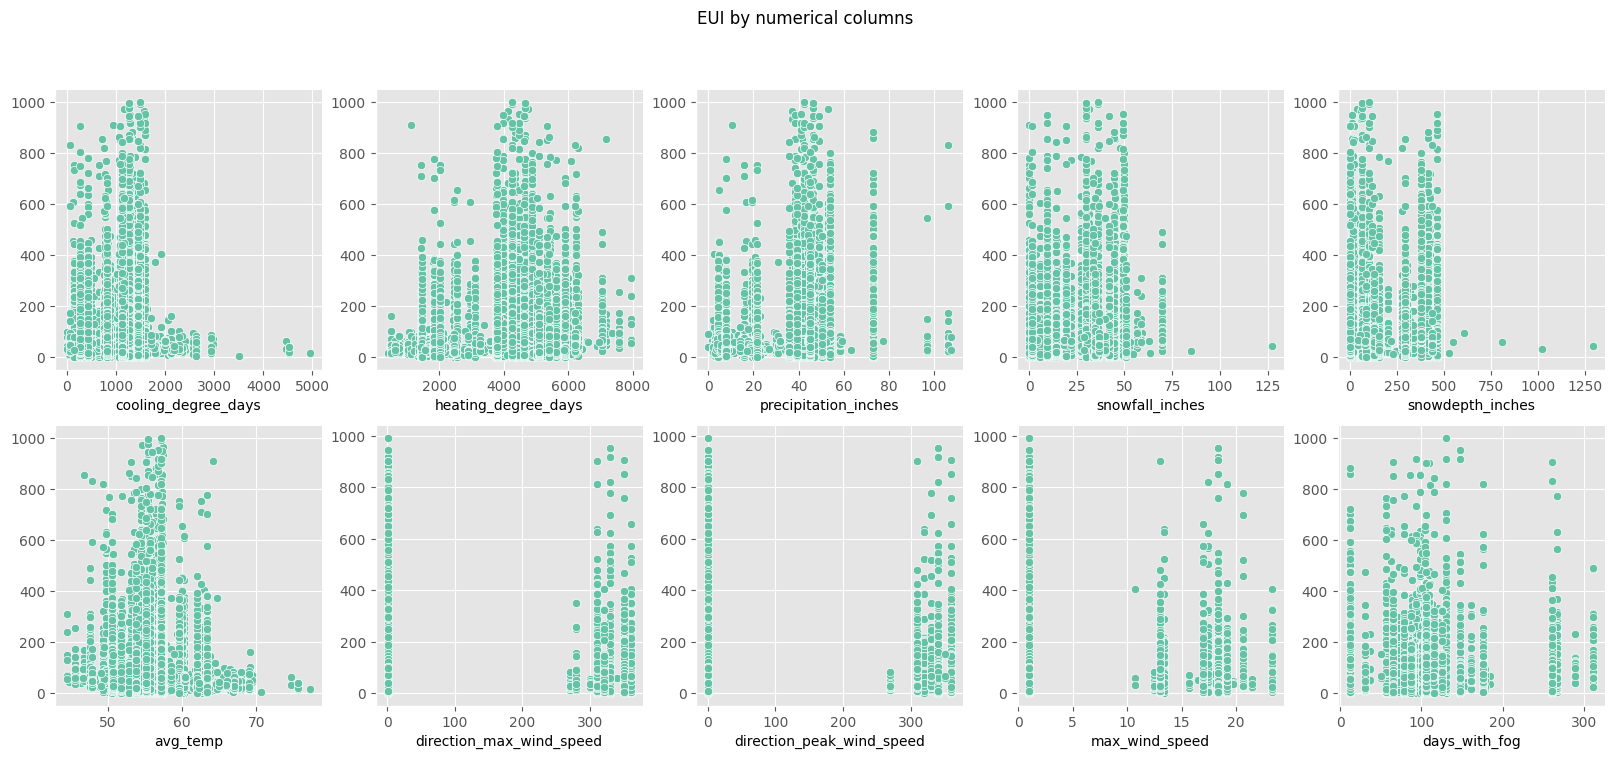

In [43]:
cols=[['cooling_degree_days','heating_degree_days', 'precipitation_inches', 
      'snowfall_inches','snowdepth_inches'], 
      ['avg_temp', 
      'direction_max_wind_speed','direction_peak_wind_speed', 'max_wind_speed', 
      'days_with_fog']]

fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('EUI by numerical columns')

for e1, l in enumerate(cols):
    for e2, col in enumerate(l):
        sns.scatterplot(data=df_all, 
                        x=col, y='site_eui', ax=ax[e1, e2]).set(ylabel=None);      

### Observations

- Categorical variables such as `State_Factor`, `building_class` and `facility_type` might have some correlation with `EUI`.
- `State_6` is not present in `test` set. State 6 removed training data should be tested.
- `floor_area`, `energe_star_rating` should be included in the modelling to be tested.
- From the plots, it's difficult to observe direct (linear) relationship between `EUI` and weather related variables. However, this doesn't deny non-linear relationships among the variables.
- Variables with more than 50% `NA` values should not be imputed (in my opinion) and better to be not included in the training set.
- Weather variables have few unique values repeated throughout the datapoints. Not sure how this duplicated values might affect the modeling and prediction.

# Preprocessing

we will suppose that two  if two buildings have the same values for these features;   
they are the same building, in other words groupby_cols = (building_id)


Removing duplicates by clubbing similar building data

In [44]:
groupby_cols = ['State_Factor','building_class','facility_type','floor_area','year_built']
df_all = df_all.sort_values(by=groupby_cols+['Year_Factor']).reset_index(drop=True)

In [45]:
df_all.loc[:,df_all.dtypes=='object'].columns

Index(['State_Factor', 'building_class', 'facility_type', 'dataset'], dtype='object')

Null imputation for categorical values: **KNN Imputing**

In [46]:
cats = ['State_Factor', 'facility_type', 'building_class']
for col in cats:
    dummies = pd.get_dummies(df_all[col], dummy_na=False)
    for ohe_col in dummies:
        df_all[f'ohe_{col}_{ohe_col}'] = dummies[ohe_col]

In [47]:
df_all

Year_Factor State_Factor building_class              facility_type  \
0                3      State_1     Commercial           Commercial_Other   
1                4      State_1     Commercial           Commercial_Other   
2                5      State_1     Commercial           Commercial_Other   
3                7      State_1     Commercial           Commercial_Other   
4                3      State_1     Commercial           Commercial_Other   
...            ...          ...            ...                        ...   
85457            7      State_8    Residential  Multifamily_Uncategorized   
85458            6      State_8    Residential  Multifamily_Uncategorized   
85459            7      State_8    Residential  Multifamily_Uncategorized   
85460            6      State_8    Residential  Multifamily_Uncategorized   
85461            7      State_8    Residential  Multifamily_Uncategorized   

       floor_area  year_built  energy_star_rating  ELEVATION  \
0         10149.0      1931.0                 NaN       45.7   
1         10149.0      1931.0                 NaN      120.4   
2         10149.0      1931.0                 NaN       59.1   
3         10149.0      1931.0                 NaN       59.1   
4         10755.0      1937.0                 NaN        9.1   
...           ...         ...                 ...        ...   
85457    900000.0      1960.0                90.0      130.8   
85458   1179072.0      1959.0                96.0        3.0   
85459   1179072.0      1959.0                92.0      130.8   
85460   1195034.0      1964.0                75.0        3.0   
85461   1195034.0      1964.0                77.0      130.8   

       january_min_temp  january_avg_temp  january_max_temp  \
0                    26         44.516129                64   
1                    41         55.096774                73   
2                    29         51.387097                77   
3                    38         50.596774                64   
4                    22         44.790323                65   
...                 ...               ...               ...   
85457                 2         33.435484                61   
85458                 8         29.827586                62   
85459                 2         33.435484                61   
85460                 8         29.827586                62   
85461                 2         33.435484                61   

       february_min_temp  february_avg_temp  february_max_temp  \
0                     30          49.392857                 69   
1                     42          54.875000                 71   
2                     36          56.803571                 75   
3                     40          54.482143                 66   
4                     25          47.892857                 71   
...                  ...                ...                ...   
85457                 16          37.660714                 73   
85458                  4          33.896552                 62   
85459                 16          37.660714                 73   
85460                  4          33.896552                 62   
85461                 16          37.660714                 73   

       march_min_temp  march_avg_temp  march_max_temp  april_min_temp  \
0                  37       55.967742              77              40   
1                  47       59.032258              76              47   
2                  40       61.435484              85              41   
3                  42       56.935484              77              45   
4                  32       53.112903              79              34   
...               ...             ...             ...             ...   
85457               8       35.935484              69              28   
85458              24       45.967742              79              18   
85459               8       35.935484              69              28   
85460              24       45.96

In [48]:
knn_imputing = False
target='site_eui'

if knn_imputing:
    imputer = KNNImputer(n_neighbors=7)
    tmp = df_all[['State_Factor', 'building_class', 'facility_type', 'dataset', target]]
    df = df_all.drop(tmp.columns, axis=1)
    df1 = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)
    
    tmp.to_csv('data/imputer_tmp.csv', index=False)
    df1.to_csv('data/imputer_df1.csv', index=False)
    joblib.dump(imputer, 'models/knn_imputer.pkl')

else:
    df1 = pd.read_csv('train_dataset.csv')
    tmp = df_all[['State_Factor', 'building_class', 'facility_type', 'dataset', target]]
    df_all = df_all.drop(tmp.columns, axis=1)
    
    for col in tmp.columns:
        df_all[col]=tmp[col]
    for col in df1.columns:
        df_all[col] = df1[col]

**Target encoding** for categorical columns.  
Target encoding is the process of replacing a categorical value with the mean of the target variable. Any non-categorical columns are automatically dropped by the target encoder model.

In [49]:
cats = ['State_Factor', 'building_class', 'facility_type']
for col in cats:
    encoder = TargetEncoder()
    df_all[f'te_{col}'] = encoder.fit_transform(df_all[col], df_all[target])

# Feature Engineering

### Weather based features

we will extract new weather statistics from the building location weather features

In [50]:
temp = [col for col in df_all.columns if 'temp' in col]

df_all['min_temp'] = df_all[temp].min(axis=1)
df_all['max_temp'] = df_all[temp].max(axis=1)
df_all['avg_temp'] = df_all[temp].mean(axis=1)
df_all['std_temp'] = df_all[temp].std(axis=1)
df_all['skew_temp'] = df_all[temp].skew(axis=1)
temp = pd.Series([col for col in df_all.columns if 'temp' in col])

winter_temp = temp[temp.apply(lambda x: ('january' in x or 'february' in x or 'december' in x))].values
spring_temp = temp[temp.apply(lambda x: ('march' in x or 'april' in x or 'may' in x))].values
summer_temp = temp[temp.apply(lambda x: ('june' in x or 'july' in x or 'august' in x))].values
autumn_temp = temp[temp.apply(lambda x: ('september' in x or 'october' in x or 'november' in x))].values


### winter
df_all['min_winter_temp'] = df_all[winter_temp].min(axis=1)
df_all['max_winter_temp'] = df_all[winter_temp].max(axis=1)
df_all['avg_winter_temp'] = df_all[winter_temp].mean(axis=1)
df_all['std_winter_temp'] = df_all[winter_temp].std(axis=1)
df_all['skew_winter_temp'] = df_all[winter_temp].skew(axis=1)
### spring
df_all['min_spring_temp'] = df_all[spring_temp].min(axis=1)
df_all['max_spring_temp'] = df_all[spring_temp].max(axis=1)
df_all['avg_spring_temp'] = df_all[spring_temp].mean(axis=1)
df_all['std_spring_temp'] = df_all[spring_temp].std(axis=1)
df_all['skew_spring_temp'] = df_all[spring_temp].skew(axis=1)
### summer
df_all['min_summer_temp'] = df_all[summer_temp].min(axis=1)
df_all['max_summer_temp'] = df_all[summer_temp].max(axis=1)
df_all['avg_summer_temp'] = df_all[summer_temp].mean(axis=1)
df_all['std_summer_temp'] = df_all[summer_temp].max(axis=1)
df_all['skew_summer_temp'] = df_all[summer_temp].max(axis=1)
## autumn
df_all['min_autumn_temp'] = df_all[autumn_temp].min(axis=1)
df_all['max_autumn_temp'] = df_all[autumn_temp].max(axis=1)
df_all['avg_autumn_temp'] = df_all[autumn_temp].mean(axis=1)
df_all['std_autumn_temp'] = df_all[autumn_temp].std(axis=1)
df_all['skew_autumn_temp'] = df_all[autumn_temp].skew(axis=1)

In [51]:
df_all['month_cooling_degree_days'] = df_all['cooling_degree_days']/12
df_all['month_heating_degree_days'] = df_all['heating_degree_days']/12

### Buildig based feature:

we will extract building statistics

In [52]:
# total area
df_all['building_area'] = df_all['floor_area'] * df_all['ELEVATION']
# rating energy by floor
df_all['floor_energy_star_rating'] = df_all['energy_star_rating']/df_all['ELEVATION']

### checking target variable transformation

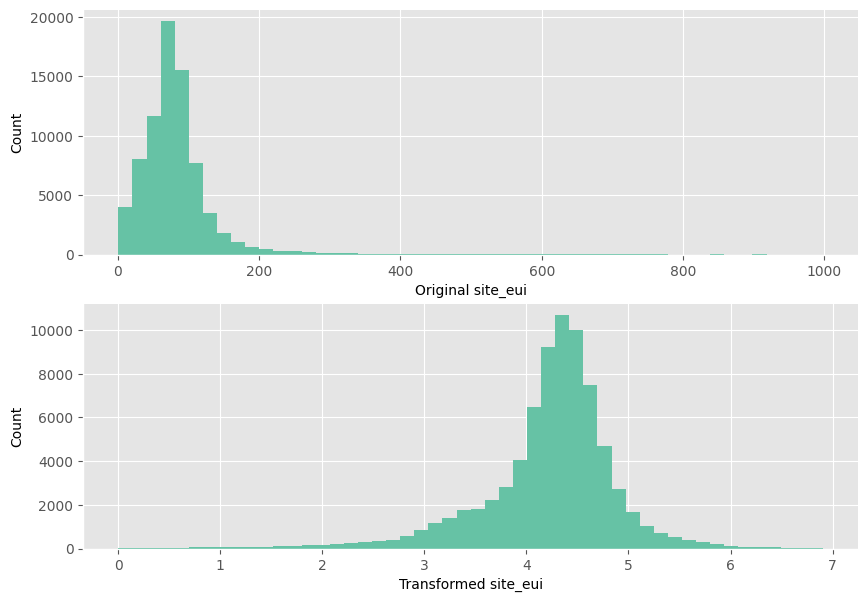

In [53]:
target = 'site_eui'
plt.figure(figsize=(10,7)) 
# plot the original variable vs sale price    
plt.subplot(2, 1, 1)
train[target].hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Original ' + target)
# plot transformed variable vs sale price
plt.subplot(2, 1, 2)
np.log(train[target]).hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Transformed ' + target);

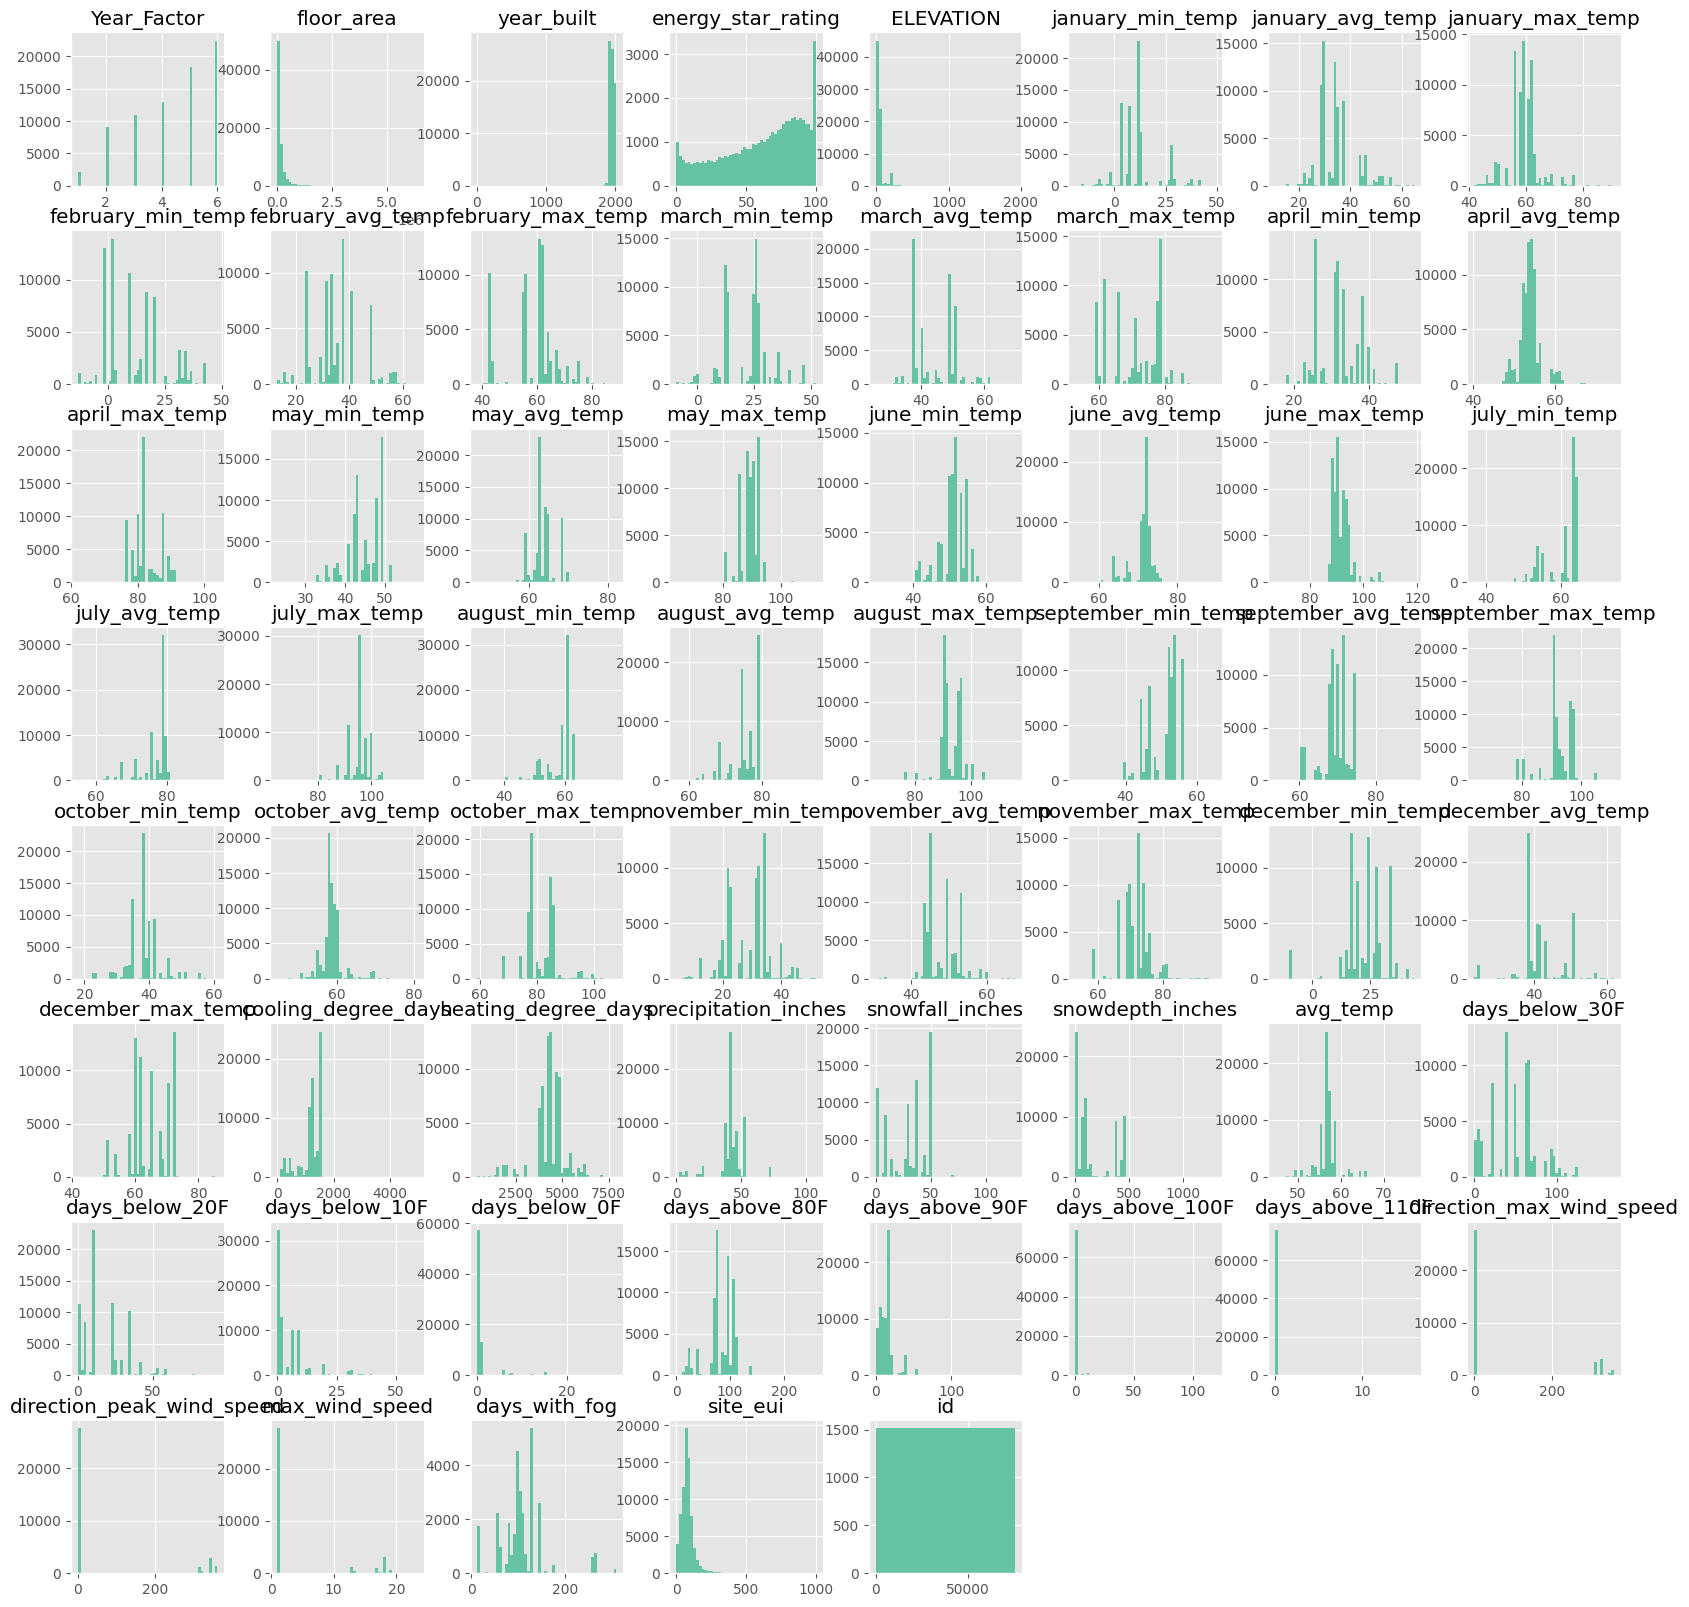

In [54]:
nums = train.loc[:, train.dtypes != 'object'].columns
df_all[nums].hist(bins=50, figsize=(20,20))
plt.show();

In [55]:
df_all[nums].skew().sort_values(key=abs, ascending=False)[:5]

days_above_110F    84.615712
days_above_100F    23.496211
year_built        -11.864499
ELEVATION           7.102841
floor_area          6.607210
dtype: float64

Binarize very skewed variables

In [56]:
skewed = ['days_above_110F', 'days_above_100F']

for var in skewed:
    
    # map the variable values into 0 and 1
    df_all[var] = np.where(df_all[var]==0, 0, 1)

### Saving feature dataset

In [57]:
saved = False
if saved:
    !pip install pickle5 --quiet
    import pickle5 as pickle
    data_path = 'Untitled Folder/feature_transformed_set.pkl'
    with open(data_path, "rb") as fh:
        df = pickle.load(fh)
else:
    df_all.to_pickle('Untitled Folder/feature_transformed_set.pkl')

In [58]:
df_all.shape

(85462, 165)

In [59]:
df_all.head()

Year_Factor  floor_area  year_built  energy_star_rating  ELEVATION  \
0          1.0     61242.0      1942.0                11.0        2.4   
1          1.0    274000.0      1955.0                45.0        1.8   
2          1.0    280025.0      1951.0                97.0        1.8   
3          1.0     55325.0      1980.0                46.0        1.8   
4          1.0     66000.0      1985.0               100.0        2.4   

   january_min_temp  january_avg_temp  january_max_temp  february_min_temp  \
0              36.0              50.5              68.0               35.0   
1              36.0              50.5              68.0               35.0   
2              36.0              50.5              68.0               35.0   
3              36.0              50.5              68.0               35.0   
4              36.0              50.5              68.0               35.0   

   february_avg_temp  february_max_temp  march_min_temp  march_avg_temp  \
0          50.589286               73.0            40.0       53.693548   
1          50.589286               73.0            40.0       53.693548   
2          50.589286               73.0            40.0       53.693548   
3          50.589286               73.0            40.0       53.693548   
4          50.589286               73.0            40.0       53.693548   

   march_max_temp  april_min_temp  april_avg_temp  april_max_temp  \
0            80.0            41.0            55.5            78.0   
1            80.0            41.0            55.5            78.0   
2            80.0            41.0            55.5            78.0   
3            80.0            41.0            55.5            78.0   
4            80.0            41.0            55.5            78.0   

   may_min_temp  may_avg_temp  may_max_temp  june_min_temp  june_avg_temp  \
0          46.0     56.854839          84.0           50.0           60.5   
1          46.0     56.854839          84.0           50.0           60.5   
2          46.0     56.854839          84.0           50.0           60.5   
3          46.0     56.854839          84.0           50.0           60.5   
4          46.0     56.854839          84.0           50.0           60.5   

   june_max_temp  july_min_temp  july_avg_temp  july_max_temp  \
0           90.0           52.0      62.725806           84.0   
1           90.0           52.0      62.725806           84.0   
2           90.0           52.0      62.725806           84.0   
3           90.0           52.0      62.725806           84.0   
4           90.0           52.0      62.725806           84.0   

   august_min_temp  august_avg_temp  august_max_temp  september_min_temp  \
0             52.0         62.16129             85.0                52.0   
1             52.0         62.16129             85.0                52.0   
2             52.0         62.16129             85.0                52.0   
3             52.0         62.16129             85.0                52.0   
4             52.0         62.16129             85.0                52.0   

   september_avg_temp  september_max_temp  october_min_temp  october_avg_temp  \
0               64.65                90.0              47.0         63.016129   
1               64.65                90.0              47.0         63.016129   
2               64.65                90.0              47.0         63.016129   
3               64.65                90.0              47.0         63.016129   
4               64.65                90.0              47.0         63.016129   

   october_max_temp  ...  building_class  \
0              83.0  ...      Commercial   
1              83.0  ...      Commercial   
2              83.0  ...      Commercial   
3              83.0  ...      Commercial   
4              83.0  ...      Commercial   

                               facility_type  dataset    site_eui  \
0               Grocery_store_or_food_market    train  248.682615   
1  Warehouse_Distribution_or

# Baseline Modeling

In [60]:
cats = ['State_Factor', 'facility_type', 'building_class', 'days_above_100F', 'days_above_110F']
#typecasting numerical features
for col in df_all.drop(columns=cats + ['dataset', 'id', 'site_eui']).columns:
    df_all[col] = df_all[col].astype('float64')

In [61]:
df_all.dropna().drop(columns=cats)

Year_Factor  floor_area  year_built  energy_star_rating  ELEVATION  \
404            2.0     34173.0      1913.0               100.0        2.4   
405            2.0     46800.0      1914.0                61.0        2.4   
406            2.0    162214.0      1924.0                35.0        2.4   
407            2.0    168000.0      1927.0                74.0        2.4   
411            2.0     99000.0      1929.0                98.0        2.4   
...            ...         ...         ...                 ...        ...   
73140          6.0     39984.0      1956.0                75.0       57.3   
73143          6.0     22324.0      1941.0                53.0       57.3   
73146          6.0     26510.0      1970.0                91.0       57.3   
73147          6.0     22058.0      1967.0                 1.0       57.3   
73148          6.0     37400.0      1922.0                73.0       57.3   

       january_min_temp  january_avg_temp  january_max_temp  \
404                27.0         48.951613              69.0   
405                27.0         48.951613              69.0   
406                27.0         48.951613              69.0   
407                27.0         48.951613              69.0   
411                27.0         48.951613              69.0   
...                 ...               ...               ...   
73140              28.0         43.451613              56.0   
73143              28.0         43.451613              56.0   
73146              28.0         43.451613              56.0   
73147              28.0         43.451613              56.0   
73148              28.0         43.451613              56.0   

       february_min_temp  february_avg_temp  february_max_temp  \
404                 33.0          51.655172               78.0   
405                 33.0          51.655172               78.0   
406                 33.0          51.655172               78.0   
407                 33.0          51.655172               78.0   
411                 33.0          51.655172               78.0   
...                  ...                ...                ...   
73140               34.0          47.672414               64.0   
73143               34.0          47.672414               64.0   
73146               34.0          47.672414               64.0   
73147               34.0          47.672414               64.0   
73148               34.0          47.672414               64.0   

       march_min_temp  march_avg_temp  march_max_temp  april_min_temp  \
404              34.0       52.822581            74.0            37.0   
405              34.0       52.822581            74.0            37.0   
406              34.0       52.822581            74.0            37.0   
407              34.0       52.822581            74.0            37.0   
411              34.0       52.822581            74.0            37.0   
...               ...             ...             ...             ...   
73140            35.0       49.354839            71.0            40.0   
73143            35.0       49.354839            71.0            40.0   
73146            35.0       49.354839            71.0            40.0   
73147            35.0       49.354839            71.0            40.0   
73148            35.0       49.354839            71.0            40.0   

       april_avg_temp  april_max_temp  may_min_temp  may_avg_temp  \
404         58.850000            90.0          45.0     64.612903   
405         58.850000            90.0          45.0     64.612903   
406         58.850000            90.0          45.0     64.612903   
407         58.850000            90.0          45.0     64.612903   
411         58.850000            90.0          45.0     64.612903   
...               ...             ...           ...           ...   
73140       56.266667            89.0          45.0     59.193548   
73143       56.266667            89.0          45.0     59.193548   
73146       56.266667            8

In [62]:
df_all.drop(columns=cats)
df_all = df_all.fillna(0)

In [63]:
df_all

Year_Factor  floor_area  year_built  energy_star_rating  ELEVATION  \
0              1.0     61242.0      1942.0                11.0        2.4   
1              1.0    274000.0      1955.0                45.0        1.8   
2              1.0    280025.0      1951.0                97.0        1.8   
3              1.0     55325.0      1980.0                46.0        1.8   
4              1.0     66000.0      1985.0               100.0        2.4   
...            ...         ...         ...                 ...        ...   
85457          0.0         0.0         0.0                 0.0        0.0   
85458          0.0         0.0         0.0                 0.0        0.0   
85459          0.0         0.0         0.0                 0.0        0.0   
85460          0.0         0.0         0.0                 0.0        0.0   
85461          0.0         0.0         0.0                 0.0        0.0   

       january_min_temp  january_avg_temp  january_max_temp  \
0                  36.0              50.5              68.0   
1                  36.0              50.5              68.0   
2                  36.0              50.5              68.0   
3                  36.0              50.5              68.0   
4                  36.0              50.5              68.0   
...                 ...               ...               ...   
85457               0.0               0.0               0.0   
85458               0.0               0.0               0.0   
85459               0.0               0.0               0.0   
85460               0.0               0.0               0.0   
85461               0.0               0.0               0.0   

       february_min_temp  february_avg_temp  february_max_temp  \
0                   35.0          50.589286               73.0   
1                   35.0          50.589286               73.0   
2                   35.0          50.589286               73.0   
3                   35.0          50.589286               73.0   
4                   35.0          50.589286               73.0   
...                  ...                ...                ...   
85457                0.0           0.000000                0.0   
85458                0.0           0.000000                0.0   
85459                0.0           0.000000                0.0   
85460                0.0           0.000000                0.0   
85461                0.0           0.000000                0.0   

       march_min_temp  march_avg_temp  march_max_temp  april_min_temp  \
0                40.0       53.693548            80.0            41.0   
1                40.0       53.693548            80.0            41.0   
2                40.0       53.693548            80.0            41.0   
3                40.0       53.693548            80.0            41.0   
4                40.0       53.693548            80.0            41.0   
...               ...             ...             ...             ...   
85457             0.0        0.000000             0.0             0.0   
85458             0.0        0.000000             0.0             0.0   
85459             0.0        0.000000             0.0             0.0   
85460             0.0        0.000000             0.0             0.0   
85461             0.0        0.000000             0.0             0.0   

       april_avg_temp  april_max_temp  may_min_temp  may_avg_temp  \
0                55.5            78.0          46.0     56.854839   
1                55.5            78.0          46.0     56.854839   
2                55.5            78.0          46.0     56.854839   
3                55.5            78.0          46.0     56.854839   
4                55.5            78.0          46.0     56.854839   
...               ...             ...           ...           ...   
85457             0.0             0.0           0.0      0.000000   
85458             0.0             0.0           0.0      0.000000   
85459             0.0             

In [64]:
train = df_all[df_all['dataset']=='train']
test = df_all[df_all['dataset']=='test']

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

test_ids = test['id']
train_ids = train['id']

target = train['site_eui'] #y_train

train = train.drop(['id', 'dataset', 'site_eui'], axis=1) #X_train
test = test.drop(['id', 'dataset', 'site_eui'], axis=1) #X_test

### Label Encoding discrete features

In [65]:
cats_discrete_idx = np.where(train.dtypes != 'float64')[0]
# create the label
le = LabelEncoder()
for col_idx in cats_discrete_idx:
    train.iloc[:, col_idx] = le.fit_transform(train.iloc[:, col_idx].astype(str))
    test.iloc[:, col_idx] = le.transform(test.iloc[:, col_idx].astype(str))

In [66]:
print("Label Encoded Columns:")
for i in cats_discrete_idx:
    print(test.columns[i])

Label Encoded Columns:
days_above_100F
days_above_110F
State_Factor
building_class
facility_type


In [67]:
y_test = pd.read_csv('y_test.csv')

X_train = train
X_test = test
y_train = target
y_test = y_test['site_eui']
print('Train: ', X_train.shape)
print('Test:', X_test.shape)
print('Samples: ', y_train.shape)
print('Targets: ', y_test.shape)

Train:  (75757, 162)
Test: (9705, 162)
Samples:  (75757,)
Targets:  (9705,)


In [68]:
y_test.dropna()
X_test.dropna()
X_train.dropna()
y_train.dropna()

0        248.682615
1         26.500150
2         24.693619
3          3.899395
4          6.597715
            ...    
75752      0.000000
75753      0.000000
75754      0.000000
75755      0.000000
75756      0.000000
Name: site_eui, Length: 75757, dtype: float64

### Catboost

In [69]:
catb = CatBoostRegressor(iterations=500,
                         learning_rate=0.02,
                         depth=12,
                         eval_metric='RMSE',
                         random_seed = 23,
                         bagging_temperature = 0.2,
                         od_type='Iter',
                         metric_period = 75,
                         od_wait=100
                        )

In [70]:
catb.fit(X_train, y_train,
                 eval_set=(X_test,y_test),
                 cat_features=cats_discrete_idx,
                 use_best_model=True,
                 verbose=True)

y_pred = catb.predict(X_test)

0:	learn: 59.9156296	test: 60.0691732	best: 60.0691732 (0)	total: 368ms	remaining: 3m 3s
75:	learn: 42.4732876	test: 64.6597494	best: 59.6869405 (10)	total: 22.1s	remaining: 2m 3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 59.68694052
bestIteration = 10

Shrink model to first 11 iterations.


In [71]:
print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

 Training data scores
 --------------------
 RMSE: 59.686940550920575
 MAE: 36.24513960000411
 MSE: 3562.530872329127
 R2: 0.01469894356264001


### XGBoost

In [72]:
xgb = XGBRegressor(n_estimators=500, reg_alpha=0.01, n_jobs=-1)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

In [73]:
print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

 Training data scores
 --------------------
 RMSE: 74.65421382336103
 MAE: 47.96708092002046
 MSE: 5573.25164158411
 R2: -0.5414128121376611


### RandomForest

In [74]:
rf = RandomForestRegressor(random_state=1, max_depth = 15, min_samples_split= 2)
rf.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

In [75]:
print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

 Training data scores
 --------------------
 RMSE: 74.65421382336103
 MAE: 47.96708092002046
 MSE: 5573.25164158411
 R2: -0.5414128121376611


# Model Evaluation

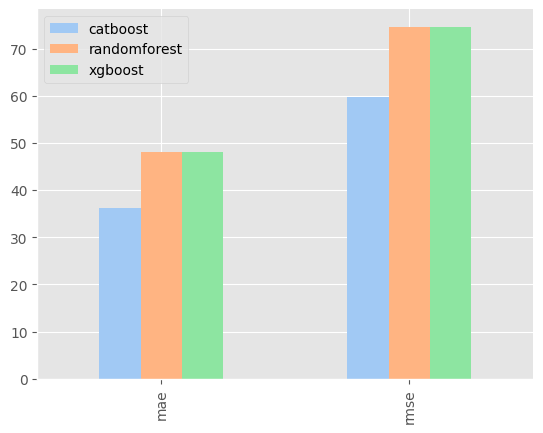

In [76]:
error_rec = {
    "catboost": {
        "mae": 36.24513960000411,
        "rmse": 59.686940550920575,
    },
    "randomforest": {
        "mae": 47.96708092002046,
        "rmse": 74.65421382336103,
    },
    "xgboost": {
        "mae": 47.96708092002046,
        "rmse": 74.65421382336103,
    },
}
pd.DataFrame(error_rec).plot(kind="bar", 
             color=[
                 sns.color_palette("pastel")[0], 
                 sns.color_palette("pastel")[1], 
                 sns.color_palette("pastel")[2], 
                 sns.color_palette("pastel")[3]]);
plt.show()

# Hyperparameter Tuning

### Using CrossValidation on CatBoost

In [77]:
train_oof = np.zeros((train.shape[0],))
test_preds = np.zeros(test.shape[0])

NUM_FOLDS = 5
kf = KFold(n_splits = NUM_FOLDS, shuffle=True, random_state=0)

for fold, (train_idx, test_idx) in tqdm.tqdm(enumerate(kf.split(train, target))):
    X_train, X_test = train.iloc[train_idx][test.columns], train.iloc[test_idx][test.columns]
    y_train, y_test = target[train_idx], target[test_idx]
    
    catb = CatBoostRegressor(iterations=500,
                         learning_rate=0.02,
                         depth=12,
                         eval_metric='RMSE',
#                         early_stopping_rounds=42,
                         random_seed = 23,
                         bagging_temperature = 0.2,
                         od_type='Iter',
                         metric_period = 75,
                         od_wait=100)
    # train model
    catb.fit(X_train, y_train,
                 eval_set=(X_test,y_test),
                 cat_features=cats_discrete_idx,
                 use_best_model=True,
                 verbose=True)

    oof = catb.predict(X_test)
    train_oof[test_idx] = oof
    test_preds += catb.predict(test)/NUM_FOLDS      
    print(f"out-of-folds prdiction ==== fold_{fold} RMSE",np.sqrt(mean_squared_error(oof, y_test, squared=False)))

0it [00:00, ?it/s]Warning: Overfitting detector is active, thus evaluation metric is calculated on every iteration. 'metric_period' is ignored for evaluation metric.


0:	learn: 59.7878480	test: 60.0131562	best: 60.0131562 (0)	total: 444ms	remaining: 3m 41s
75:	learn: 42.7069322	test: 42.7562049	best: 42.7562049 (75)	total: 20.5s	remaining: 1m 54s
150:	learn: 39.3652891	test: 40.2723312	best: 40.2723312 (150)	total: 43.4s	remaining: 1m 40s
225:	learn: 37.9137653	test: 39.5450510	best: 39.5450510 (225)	total: 1m 5s	remaining: 1m 19s
300:	learn: 37.1073565	test: 39.2824154	best: 39.2824154 (300)	total: 1m 29s	remaining: 59.5s
375:	learn: 36.3701583	test: 39.0959324	best: 39.0959324 (375)	total: 1m 52s	remaining: 37s
450:	learn: 35.8459585	test: 38.9665359	best: 38.9665118 (449)	total: 2m 9s	remaining: 14.1s
499:	learn: 35.4647270	test: 38.8648429	best: 38.8648429 (499)	total: 2m 22s	remaining: 0us

bestTest = 38.86484292
bestIteration = 499



1it [02:24, 144.04s/it]

out-of-folds prdiction ==== fold_0 RMSE 6.234167379962485


0:	learn: 59.3670304	test: 61.7183648	best: 61.7183648 (0)	total: 368ms	remaining: 3m 3s
75:	learn: 42.0073669	test: 45.9544486	best: 45.9544486 (75)	total: 20.7s	remaining: 1m 55s
150:	learn: 38.7351395	test: 43.8170102	best: 43.8170102 (150)	total: 42.5s	remaining: 1m 38s
225:	learn: 37.2541060	test: 43.1131007	best: 43.1131007 (225)	total: 1m	remaining: 1m 13s
300:	learn: 36.2570005	test: 42.7894498	best: 42.7894498 (300)	total: 1m 22s	remaining: 54.3s
375:	learn: 35.5428154	test: 42.5790840	best: 42.5790840 (375)	total: 1m 43s	remaining: 34.3s
450:	learn: 34.9238092	test: 42.4744195	best: 42.4744195 (450)	total: 2m 13s	remaining: 14.5s
499:	learn: 34.5868472	test: 42.3857529	best: 42.3857529 (499)	total: 2m 30s	remaining: 0us

bestTest = 42.38575289
bestIteration = 499



2it [04:56, 148.89s/it]

out-of-folds prdiction ==== fold_1 RMSE 6.510434153857181


0:	learn: 60.5749982	test: 56.8639509	best: 56.8639509 (0)	total: 502ms	remaining: 4m 10s
75:	learn: 43.1207382	test: 40.3821730	best: 40.3821730 (75)	total: 27.1s	remaining: 2m 31s
150:	learn: 39.6577817	test: 38.1687868	best: 38.1687868 (150)	total: 51s	remaining: 1m 57s
225:	learn: 38.1788717	test: 37.6200128	best: 37.6200128 (225)	total: 1m 15s	remaining: 1m 32s
300:	learn: 37.3990886	test: 37.4310008	best: 37.4310008 (300)	total: 1m 40s	remaining: 1m 6s
375:	learn: 36.7556701	test: 37.2900493	best: 37.2900493 (375)	total: 2m 4s	remaining: 41s
450:	learn: 36.1489027	test: 37.1625401	best: 37.1608257 (448)	total: 2m 30s	remaining: 16.4s
499:	learn: 35.7893251	test: 37.0982247	best: 37.0980900 (497)	total: 2m 51s	remaining: 0us

bestTest = 37.09808998
bestIteration = 497

Shrink model to first 498 iterations.


3it [07:49, 159.89s/it]

out-of-folds prdiction ==== fold_2 RMSE 6.090820134195986


0:	learn: 59.7437069	test: 60.3279566	best: 60.3279566 (0)	total: 358ms	remaining: 2m 58s
75:	learn: 42.4855573	test: 44.3310048	best: 44.3310048 (75)	total: 26.4s	remaining: 2m 27s
150:	learn: 39.0892324	test: 41.8920892	best: 41.8920892 (150)	total: 54.1s	remaining: 2m 4s
225:	learn: 37.5924990	test: 41.1543926	best: 41.1543926 (225)	total: 1m 17s	remaining: 1m 34s
300:	learn: 36.7263223	test: 40.8658467	best: 40.8658467 (300)	total: 1m 40s	remaining: 1m 6s
375:	learn: 36.0329466	test: 40.6773968	best: 40.6773968 (375)	total: 2m 8s	remaining: 42.2s
450:	learn: 35.3837755	test: 40.5167402	best: 40.5167402 (450)	total: 2m 31s	remaining: 16.4s
499:	learn: 34.9889400	test: 40.4296932	best: 40.4296932 (499)	total: 2m 56s	remaining: 0us

bestTest = 40.42969324
bestIteration = 499



4it [10:47, 167.06s/it]

out-of-folds prdiction ==== fold_3 RMSE 6.358434814860036


0:	learn: 59.7631083	test: 60.2509457	best: 60.2509457 (0)	total: 465ms	remaining: 3m 51s
75:	learn: 42.4806013	test: 44.2050483	best: 44.2050483 (75)	total: 31.1s	remaining: 2m 53s
150:	learn: 38.9559833	test: 41.8272236	best: 41.8272236 (150)	total: 1m 13s	remaining: 2m 50s
225:	learn: 37.6777181	test: 41.2616735	best: 41.2616735 (225)	total: 1m 50s	remaining: 2m 13s
300:	learn: 36.9497334	test: 41.0330902	best: 41.0330787 (298)	total: 2m 24s	remaining: 1m 35s
375:	learn: 36.2048327	test: 40.7600405	best: 40.7600405 (375)	total: 2m 52s	remaining: 56.9s
450:	learn: 35.6526269	test: 40.5828978	best: 40.5828978 (450)	total: 3m 21s	remaining: 21.8s
499:	learn: 35.3207444	test: 40.4822646	best: 40.4822646 (499)	total: 3m 37s	remaining: 0us

bestTest = 40.48226461
bestIteration = 499



5it [14:27, 173.51s/it]

out-of-folds prdiction ==== fold_4 RMSE 6.362567452006226


### Using Optuna with Random Forest

In [78]:
kfolds = KFold(n_splits=3, shuffle=True, random_state=42)

# Objective function
def random_forest_objective(trial, data=X_train, target=y_train):
    # Dictionary to store best parameters
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 5, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "max_features": trial.suggest_float("max_features", 0.01, 0.95)
    }
     
    model = RandomForestRegressor(**param)
    
    # Setting random seed and kfolds for cross-validation
    kfolds = KFold(n_splits=10, shuffle=True, random_state=42)
    
    scores = cross_val_score(model, data, target, cv=kfolds, scoring="neg_root_mean_squared_error")
    return scores.mean()

In [79]:
def tuner(objective, n=5, direction='minimize'): 
    # Create Study object
    study = optuna.create_study(direction="minimize")

    # Optimize the study
    study.optimize(objective, n_trials=n)

    # Print the result
    best_params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}")
    print(f"Optimized parameters: {best_params}\n")
    print("<<<<<<<<<< Tuning complete... >>>>>>>>>>")
    
    # Return best parameters for the model
    return best_params, best_score

In [80]:
%%time
rf_param =  tuner(random_forest_objective,1)
rf_tuned_model = RandomForestRegressor(random_state=1, max_depth = 15, min_samples_split= 2)


[I 2023-05-25 23:59:20,537] A new study created in memory with name: no-name-82a9067d-1dc6-466f-9a84-c1204aa63eb9
[I 2023-05-26 00:09:48,313] Trial 0 finished with value: -40.505793552208786 and parameters: {'n_estimators': 359, 'max_depth': 16, 'min_samples_split': 5, 'max_features': 0.2040963573550023}. Best is trial 0 with value: -40.505793552208786.


Best score: -40.505793552208786
Optimized parameters: {'n_estimators': 359, 'max_depth': 16, 'min_samples_split': 5, 'max_features': 0.2040963573550023}

<<<<<<<<<< Tuning complete... >>>>>>>>>>
CPU times: user 9min 56s, sys: 7.95 s, total: 10min 4s
Wall time: 10min 27s


In [81]:
rf_tuned_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, random_state=1)

### Final Evaluation

Text(0.5, 0, 'iteration')

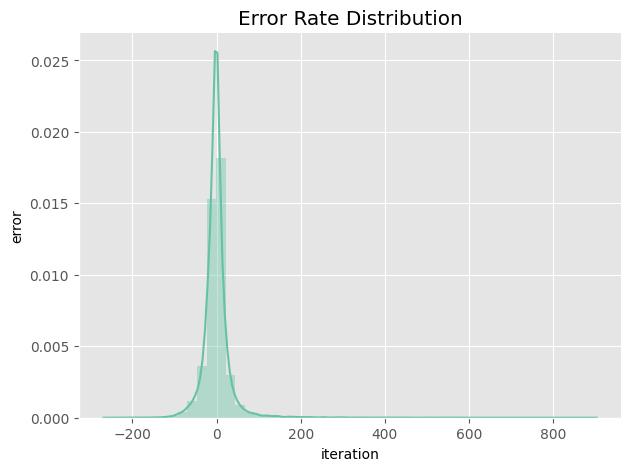

In [82]:
y_hat_tuned = catb.predict(X_test)

plt.figure(figsize = (7,5))
sns.distplot(y_test - y_hat_tuned)
plt.title("Error Rate Distribution");
plt.ylabel("error")
plt.xlabel("iteration")

Text(0.5, 0, 'iteration')

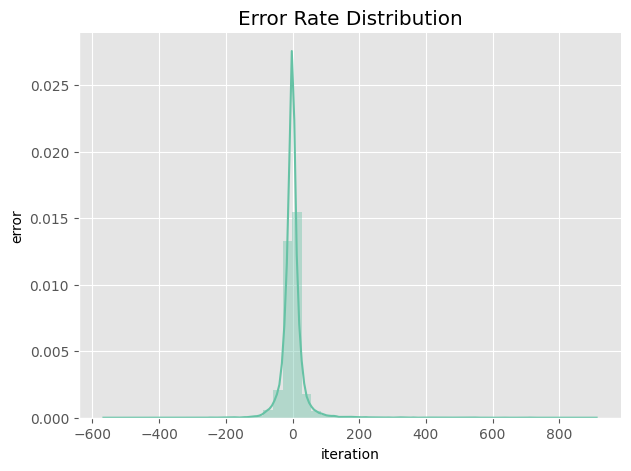

In [83]:
y_hat_tuned = rf_tuned_model.predict(X_test)

plt.figure(figsize = (7,5))
sns.distplot(y_test - y_hat_tuned)
plt.title("Error Rate Distribution");
plt.ylabel("error")
plt.xlabel("iteration")

### Saving Models

In [84]:
joblib.dump(rf, 'rf_tuned_final.joblib')

['rf_tuned_final.joblib']

In [85]:
with open('rf_tuned_final.joblib', 'wb') as f:
    joblib.dump(rf_tuned_model, f, compress=1)

with open('catb_best_final.joblib', 'wb') as f:
    joblib.dump(catb,f,compress=3)

In [86]:
## Load models here
load = False
if load:
    with open('rf_tuned_final.joblib', 'rb') as f:
        rf = joblib.load(f)

    with open('catb_best_final.joblib', 'rb') as f:
        catb = joblib.load(f)

# Explainable AI

pick your sample to study the model upon

In [87]:
shap.initjs()

In [88]:
X_sample = X_train.sample(100)

In [89]:
shap_values = shap.TreeExplainer(xgb).shap_values(X_sample)

In [90]:
shap.TreeExplainer(xgb).expected_value

array([0.5])

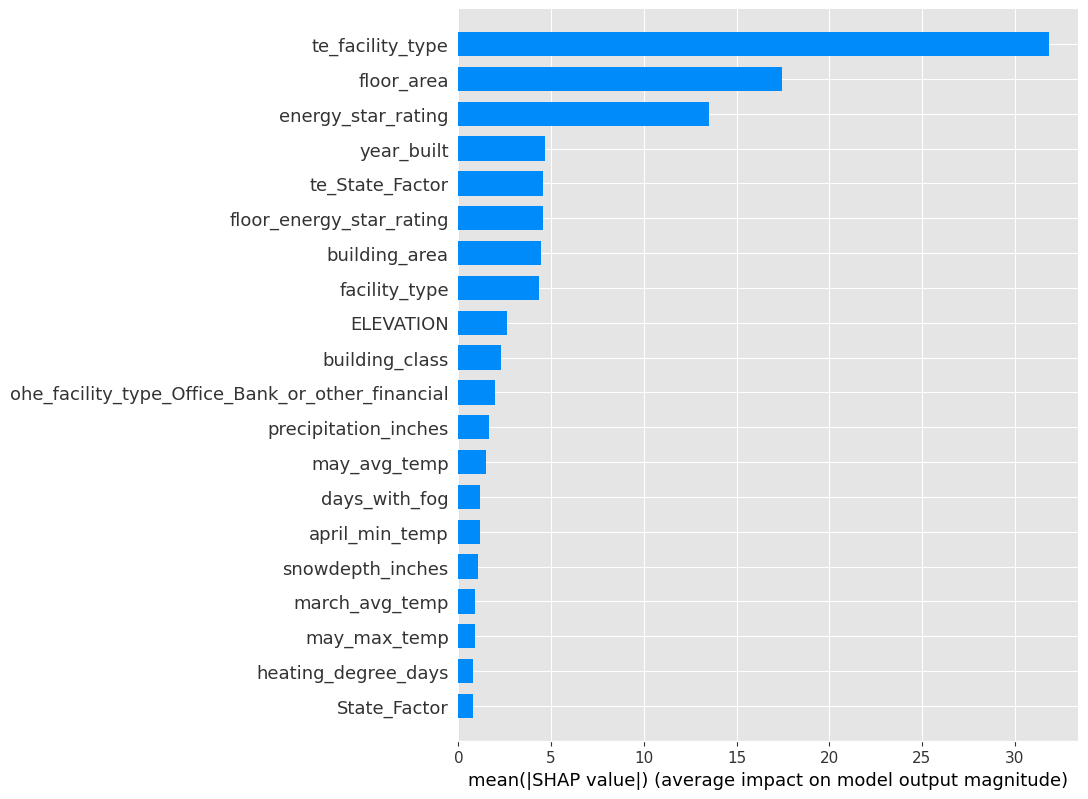

In [91]:
shap.summary_plot(shap_values, X_sample, plot_type="bar")

In [92]:
shap.force_plot(shap.TreeExplainer(rf_tuned_model).expected_value[0], shap_values, X_sample)

In [93]:
size = 2000

sample_exists = True
if sample_exists:
    sample_set = pd.read_csv('sample_solution.csv')
else:
    sample_set = X_test.sample(2000)
sample_set

id  site_eui
0     75757       0.0
1     75758       0.0
2     75759       0.0
3     75760       0.0
4     75761       0.0
...     ...       ...
9700  85457       0.0
9701  85458       0.0
9702  85459       0.0
9703  85460       0.0
9704  85461       0.0

[9705 rows x 2 columns]

calculate shap values

In [94]:
is_saved = True

if is_saved:
    with open('cb_model.pkl', 'rb') as f:
        shap_values = joblib.load(f)
else:
    shap_values = shap.TreeExplainer(model).shap_values(sample_set)

In [95]:
shap.initjs()

In [96]:
X_sample = X_train.sample(2000)
X_sample

Year_Factor  floor_area  year_built  energy_star_rating  ELEVATION  \
63960          5.0     63670.0      1991.0                50.0       18.3   
29731          4.0    340718.0      1991.0                12.0       42.7   
53786          6.0     59408.0      1914.0                85.0       42.7   
25919          4.0    137923.0      1924.0                92.0        3.4   
52402          6.0    517274.0      1977.0                91.0       42.7   
...            ...         ...         ...                 ...        ...   
25452          4.0    120900.0      1951.0                91.0        9.1   
53349          6.0    115769.0      1922.0                64.0       42.7   
51140          6.0    369450.0      1957.0                66.0        3.4   
11718          1.0     72307.0      1952.0                47.0       42.7   
58993          5.0    103240.0      1818.0                 0.0      291.4   

       january_min_temp  january_avg_temp  january_max_temp  \
63960              28.0         45.419355              63.0   
29731               4.0         28.596774              58.0   
53786              11.0         34.451613              59.0   
25919               4.0         28.596774              58.0   
52402              11.0         34.451613              59.0   
...                 ...               ...               ...   
25452               4.0         28.596774              58.0   
53349              11.0         34.451613              59.0   
51140              11.0         34.451613              59.0   
11718               6.0         29.677419              53.0   
58993               3.0         24.016129              49.0   

       february_min_temp  february_avg_temp  february_max_temp  \
63960               32.0          48.321429               62.0   
29731                9.0          31.625000               56.0   
53786               -1.0          37.706897               61.0   
25919                9.0          31.625000               56.0   
52402               -1.0          37.706897               61.0   
...                  ...                ...                ...   
25452                9.0          31.625000               56.0   
53349               -1.0          37.706897               61.0   
51140               -1.0          37.706897               61.0   
11718               15.0          36.035714               67.0   
58993               -5.0          18.910714               44.0   

       march_min_temp  march_avg_temp  march_max_temp  april_min_temp  \
63960            29.0       50.725806            71.0            37.0   
29731            13.0       37.661290            66.0            31.0   
53786            26.0       48.870968            79.0            26.0   
25919            13.0       37.661290            66.0            31.0   
52402            26.0       48.870968            79.0            26.0   
...               ...             ...             ...             ...   
25452            13.0       37.661290            66.0            31.0   
53349            26.0       48.870968            79.0            26.0   
51140            26.0       48.870968            79.0            26.0   
11718            20.0       42.322581            77.0            35.0   
58993            -1.0       32.532258            65.0            25.0   

       april_avg_temp  april_max_temp  may_min_temp  may_avg_temp  \
63960       51.850000            78.0          41.0     59.080645   
29731       52.333333            77.0          49.0     64.000000   
53786       53.333333            82.0          43.0     62.790323   
25919       52.333333            77.0          49.0     64.000000   
52402       53.333333            82.0          43.0     62.790323   
...               ...             ...           ...           ...   
25452       52.333333            77.0          49.0     64.000000   
53349       53.333333            82.0          43.0     62.790323   
51140       53.333333            8

In [97]:
shap_values = shap.TreeExplainer(catb).shap_values(X_sample)

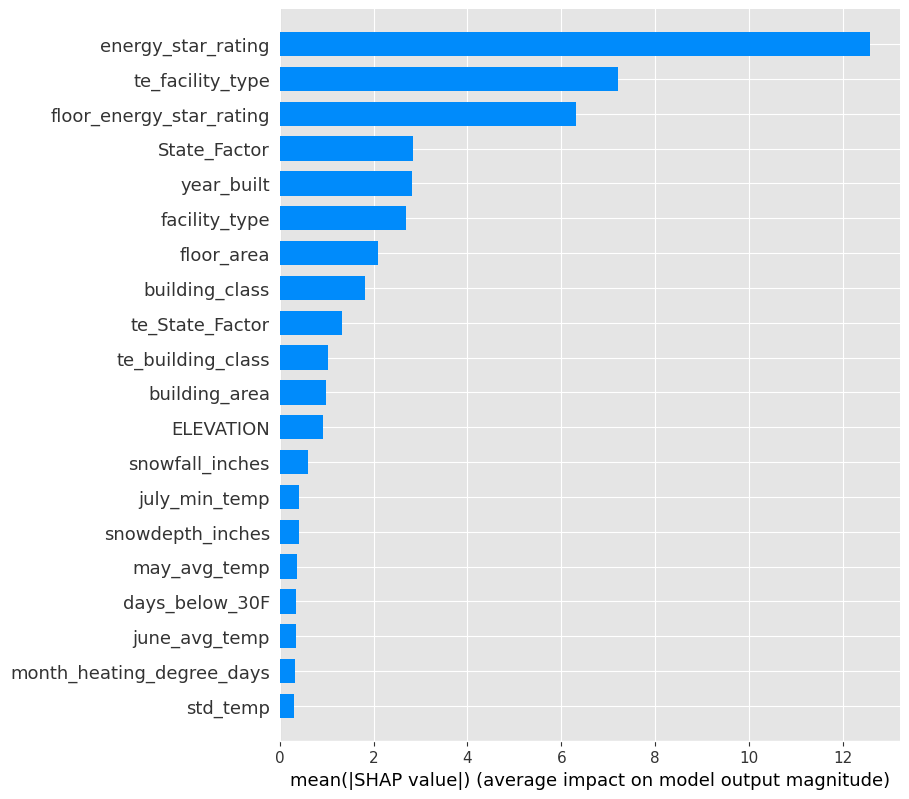

In [98]:
shap.summary_plot(shap_values, X_sample, plot_type="bar")

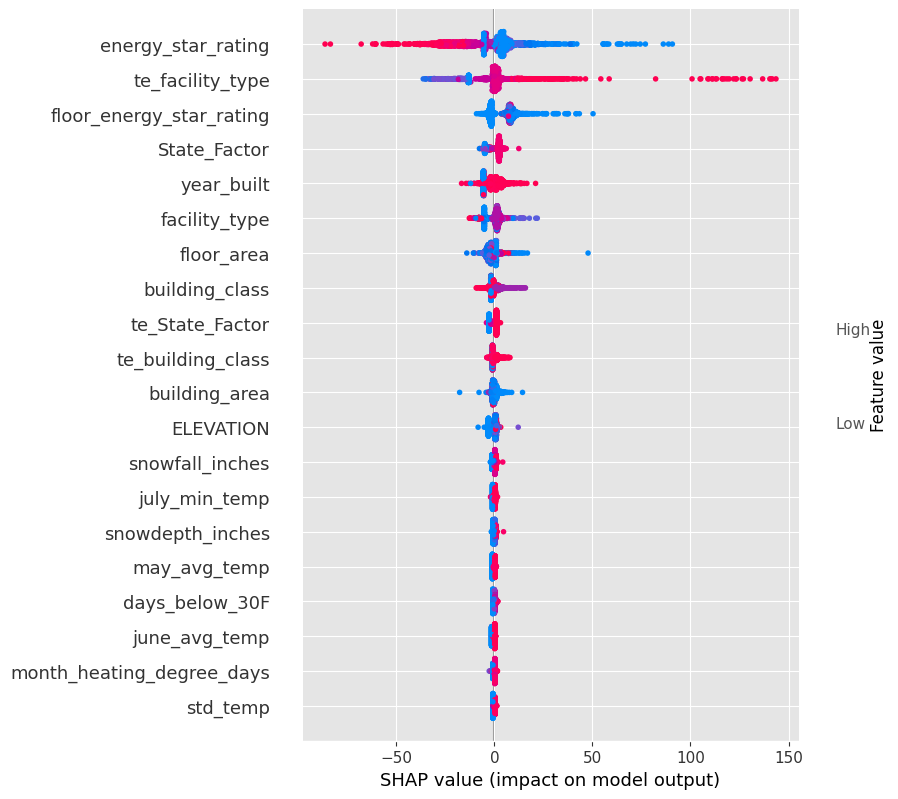

In [99]:
shap.summary_plot(shap_values, X_sample)

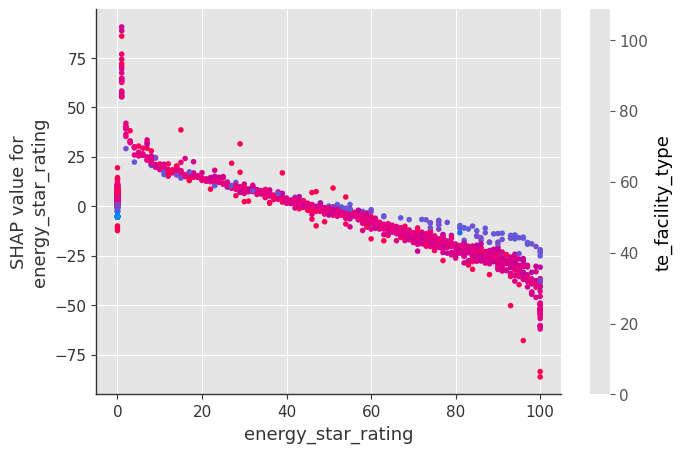

In [100]:
shap.dependence_plot('energy_star_rating', shap_values, X_sample)

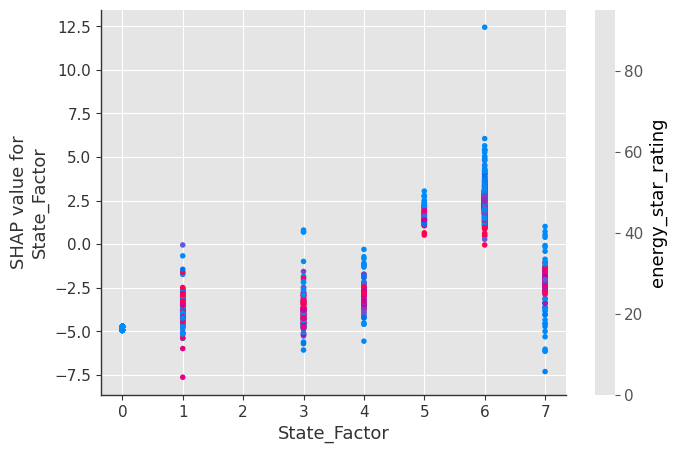

In [101]:
shap.dependence_plot('State_Factor', shap_values, X_sample)